# ML-Based Multi-Criteria Screening of Sustainable Electrochemical Materials for CO₂ Conversion and Energy Storage

**Author**: Sunny Chukwuemeka Eke 

**Date Started**: July 2025  

**Goal**: Use machine learning to predict and rank materials suitable for both CO₂ reduction and energy storage, based on a combination of performance and feasibility descriptors.

## 1. Project Overview

### 🌍 Background
Climate change and the global transition to renewable energy demand sustainable solutions for both CO₂ reduction and energy storage. Materials that can serve dual purposes, converting CO₂ into useful products while storing energy, are promising but difficult to identify due to performance trade-offs and costly trial-and-error experimentation.

### 🎯 Objective
This project applies supervised machine learning techniques to:
- Predict electrochemical and physical properties of candidate materials (e.g., MOFs, composites)
- Compute a composite “suitability score”
- Rank materials based on performance, stability, and cost-effectiveness

### 🧠 Methods
We will use open materials databases and/or literature-derived datasets to:
- Build a clean dataset of relevant descriptors and targets
- Train interpretable ML models 
- Use SHAP and feature importance to understand what features matter
- Visualize and rank top materials

### 📈 Deliverables
- A working ML model
- Suitability rankings
- Clear visualizations
- Clean documentation for GitHub and LinkedIn.

In [1]:
!pip install xgboost


In [2]:
!pip install shap


In [3]:
# Basic data science imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Interpretability
import shap

# Notebook setup
import warnings
warnings.filterwarnings('ignore')
plt.style.use('ggplot')  # or 'default'
sns.set_palette('muted')

print("All core libraries loaded.")


All core libraries loaded.


In [4]:
!pip install ipywidgets


## 2. Mock Dataset Creation

To prototype and test our ML pipeline, we create a mock dataset representing key descriptors and target performance metrics of candidate electrochemical materials.

This mock data simulates realistic but hypothetical values for:
- Structural and electronic features (e.g., bandgap, conductivity)
- Feasibility and cost (e.g., synthesis complexity, raw material cost)
- Application performance (e.g., overpotential, faradaic efficiency, capacitance)

This will allow us to:
- Train regression models
- Create a composite score
- Rank materials based on multi-criteria evaluation


In [5]:
import pandas as pd
import numpy as np

# Set seed for reproducibility
np.random.seed(42)

# Create a mock dataset of 20 materials
materials = [f"Material-{i+1}" for i in range(20)]

data = {
    'material_id': materials,
    'bandgap_eV': np.round(np.random.uniform(0.5, 3.5, 20), 2),
    'electrical_conductivity': np.round(np.random.uniform(10, 1000, 20), 1),  # S/cm
    'specific_surface_area': np.round(np.random.uniform(200, 2000, 20), 1),   # m²/g
    'stability_score': np.round(np.random.uniform(0.6, 1.0, 20), 2),          # 1 = most stable
    'synthesis_complexity': np.round(np.random.uniform(0.3, 1.0, 20), 2),     # lower = simpler
    'raw_material_cost': np.round(np.random.uniform(5, 50, 20), 2),           # $/kg

    # Targets
    'co2rr_overpotential': np.round(np.random.uniform(0.3, 0.7, 20), 2),      # V (lower = better)
    'faradaic_efficiency': np.round(np.random.uniform(65, 95, 20), 1),       # % (higher = better)
    'specific_capacitance': np.round(np.random.uniform(100, 300, 20), 1)     # F/g
}

df = pd.DataFrame(data)

# Show the first few rows
df.head()


,material_id,bandgap_eV,electrical_conductivity,specific_surface_area,stability_score,synthesis_complexity,raw_material_cost,co2rr_overpotential,faradaic_efficiency,specific_capacitance
0,Material-1,1.62,615.7,419.7,0.76,0.90,6.41,0.62,93.9,173.6
1,Material-2,3.35,148.1,1091.3,0.71,0.74,33.64,0.66,72.6,226.5
2,Material-3,2.70,299.2,261.9,0.93,0.53,19.15,0.43,79.9,226.7
3,Material-4,2.30,372.7,1836.8,0.74,0.34,27.89,0.34,74.0,207.2
4,Material-5,0.97,461.5,665.8,0.71,0.52,45.84,0.39,73.5,118.1


## 3. Exploratory Data Analysis (EDA)

In this section, we explore the mock dataset to:
- Understand the distributions of each feature
- Check for outliers or missing values
- Identify correlations between material descriptors and target properties
- Guide decisions for scaling, feature selection, and modeling

The goal is to build understanding about which features might be most influential in predicting CO₂RR or energy storage performance.


In [6]:
# Basic structure and summary of the dataset
print("Dataset shape:", df.shape)
print("\nColumn types and non-null counts:")
print(df.info())

print("\nSummary statistics:")
df.describe().T


Dataset shape: (20, 10)

Column types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   material_id              20 non-null     object 
 1   bandgap_eV               20 non-null     float64
 2   electrical_conductivity  20 non-null     float64
 3   specific_surface_area    20 non-null     float64
 4   stability_score          20 non-null     float64
 5   synthesis_complexity     20 non-null     float64
 6   raw_material_cost        20 non-null     float64
 7   co2rr_overpotential      20 non-null     float64
 8   faradaic_efficiency      20 non-null     float64
 9   specific_capacitance     20 non-null     float64
dtypes: float64(9), object(1)
memory usage: 1.7+ KB
None

Summary statistics:


,count,mean,std,min,25%,50%,75%,max
bandgap_eV,20.0,1.8730,0.923256,0.56,1.0500,1.71,2.6400,3.41
electrical_conductivity,20.0,460.2850,288.266292,56.00,200.4750,453.65,633.6250,966.00
specific_surface_area,20.0,1081.9500,595.431700,261.90,547.7750,1113.70,1649.0750,1945.30
stability_score,20.0,0.7845,0.125215,0.60,0.6750,0.75,0.9100,0.99
synthesis_complexity,20.0,0.6415,0.187793,0.32,0.5275,0.66,0.8025,0.92
raw_material_cost,20.0,28.0305,13.717538,6.41,15.9900,28.58,41.2200,46.84
co2rr_overpotential,20.0,0.4985,0.121710,0.30,0.4200,0.47,0.6225,0.69
faradaic_efficiency,20.0,78.7750,8.942440,66.10,72.2750,76.85,85.6000,94.60
specific_capacitance,20.0,186.3900,54.859053,103.30,136.7000,189.85,227.2750,287.30


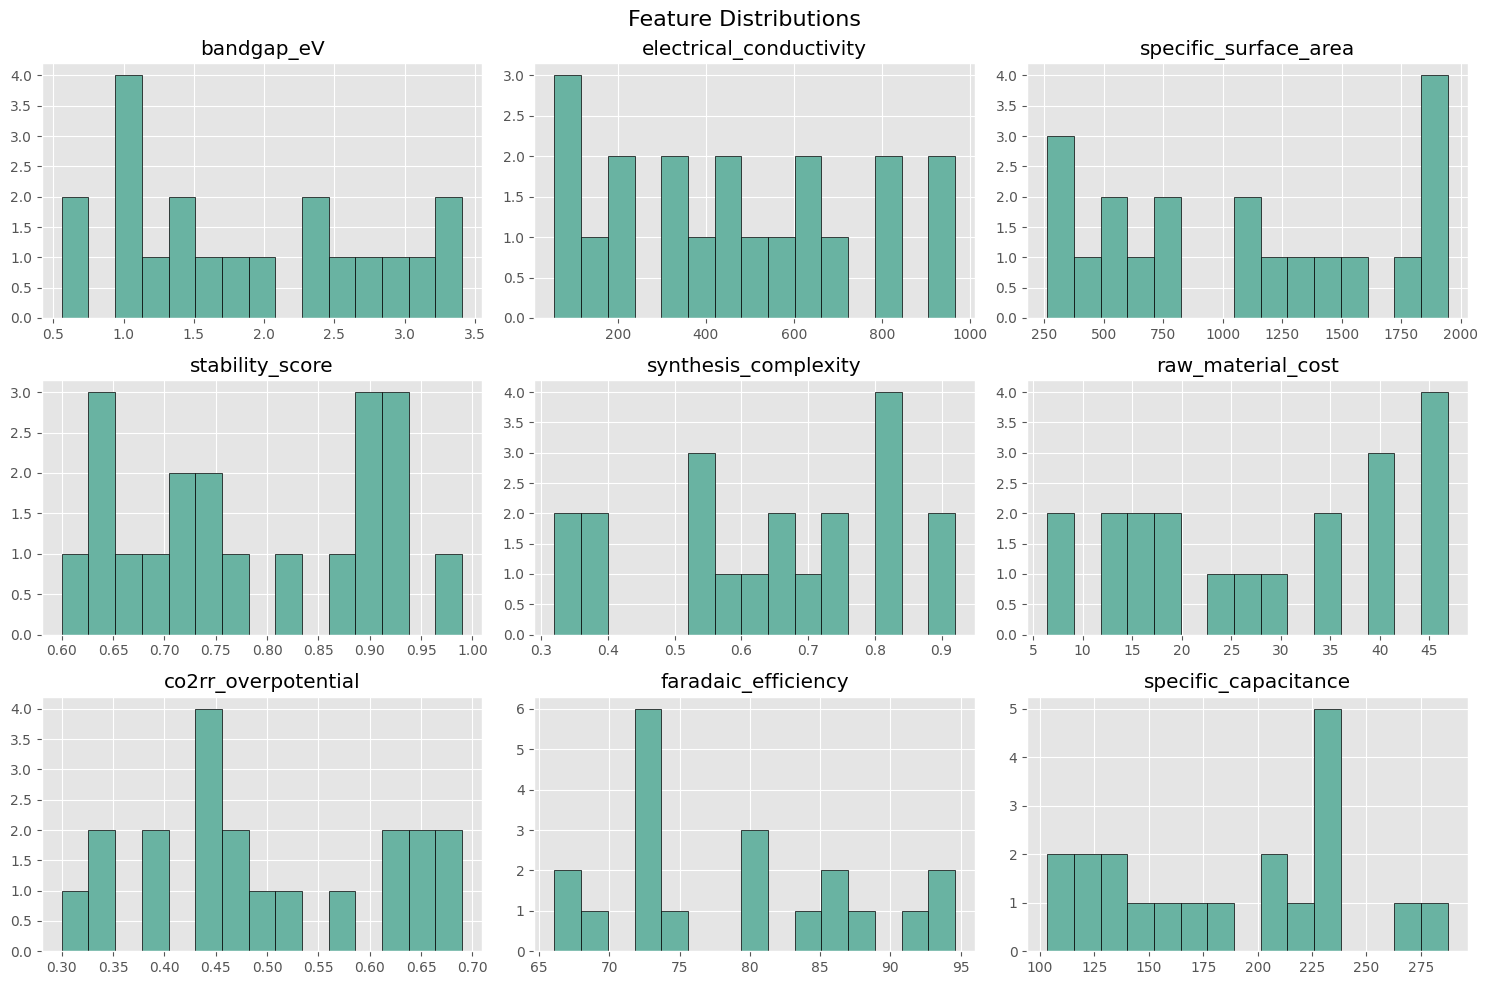

In [7]:
import matplotlib.pyplot as plt

# Plot all feature distributions (excluding material_id)
numeric_cols = df.select_dtypes(include=np.number).columns

df[numeric_cols].hist(bins=15, figsize=(15, 10), color='#69b3a2', edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=16)
plt.tight_layout()
plt.show()


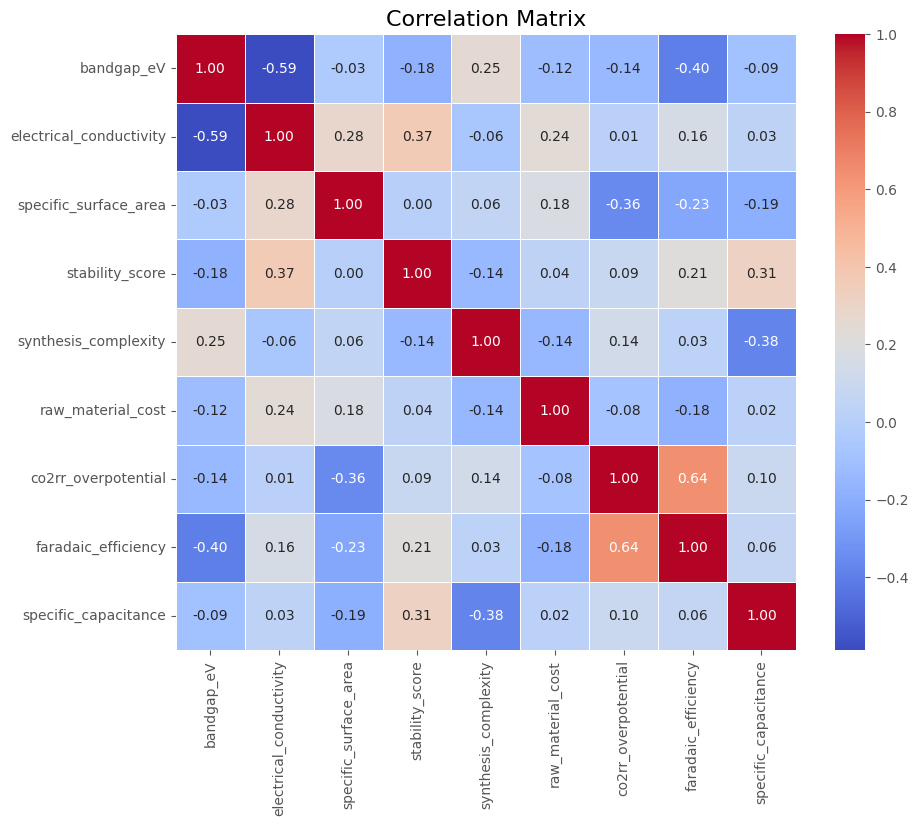

In [8]:
import seaborn as sns

plt.figure(figsize=(10, 8))
corr = df[numeric_cols].corr()

sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=16)
plt.show()


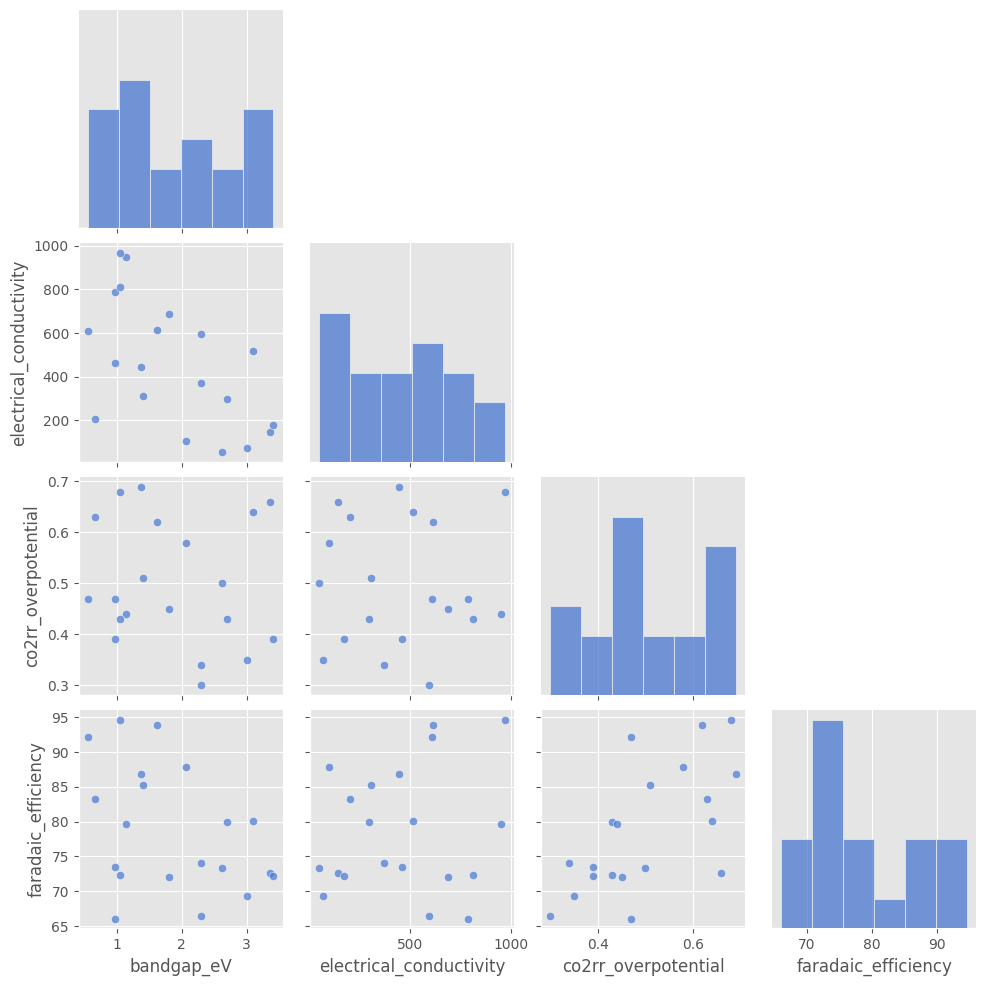

In [9]:
import seaborn as sns

# Small pairplot to visualize relationships between a few key variables
selected_features = ['bandgap_eV', 'electrical_conductivity', 'co2rr_overpotential', 'faradaic_efficiency']
sns.pairplot(df[selected_features], kind='scatter', corner=True, plot_kws={'alpha': 0.7})


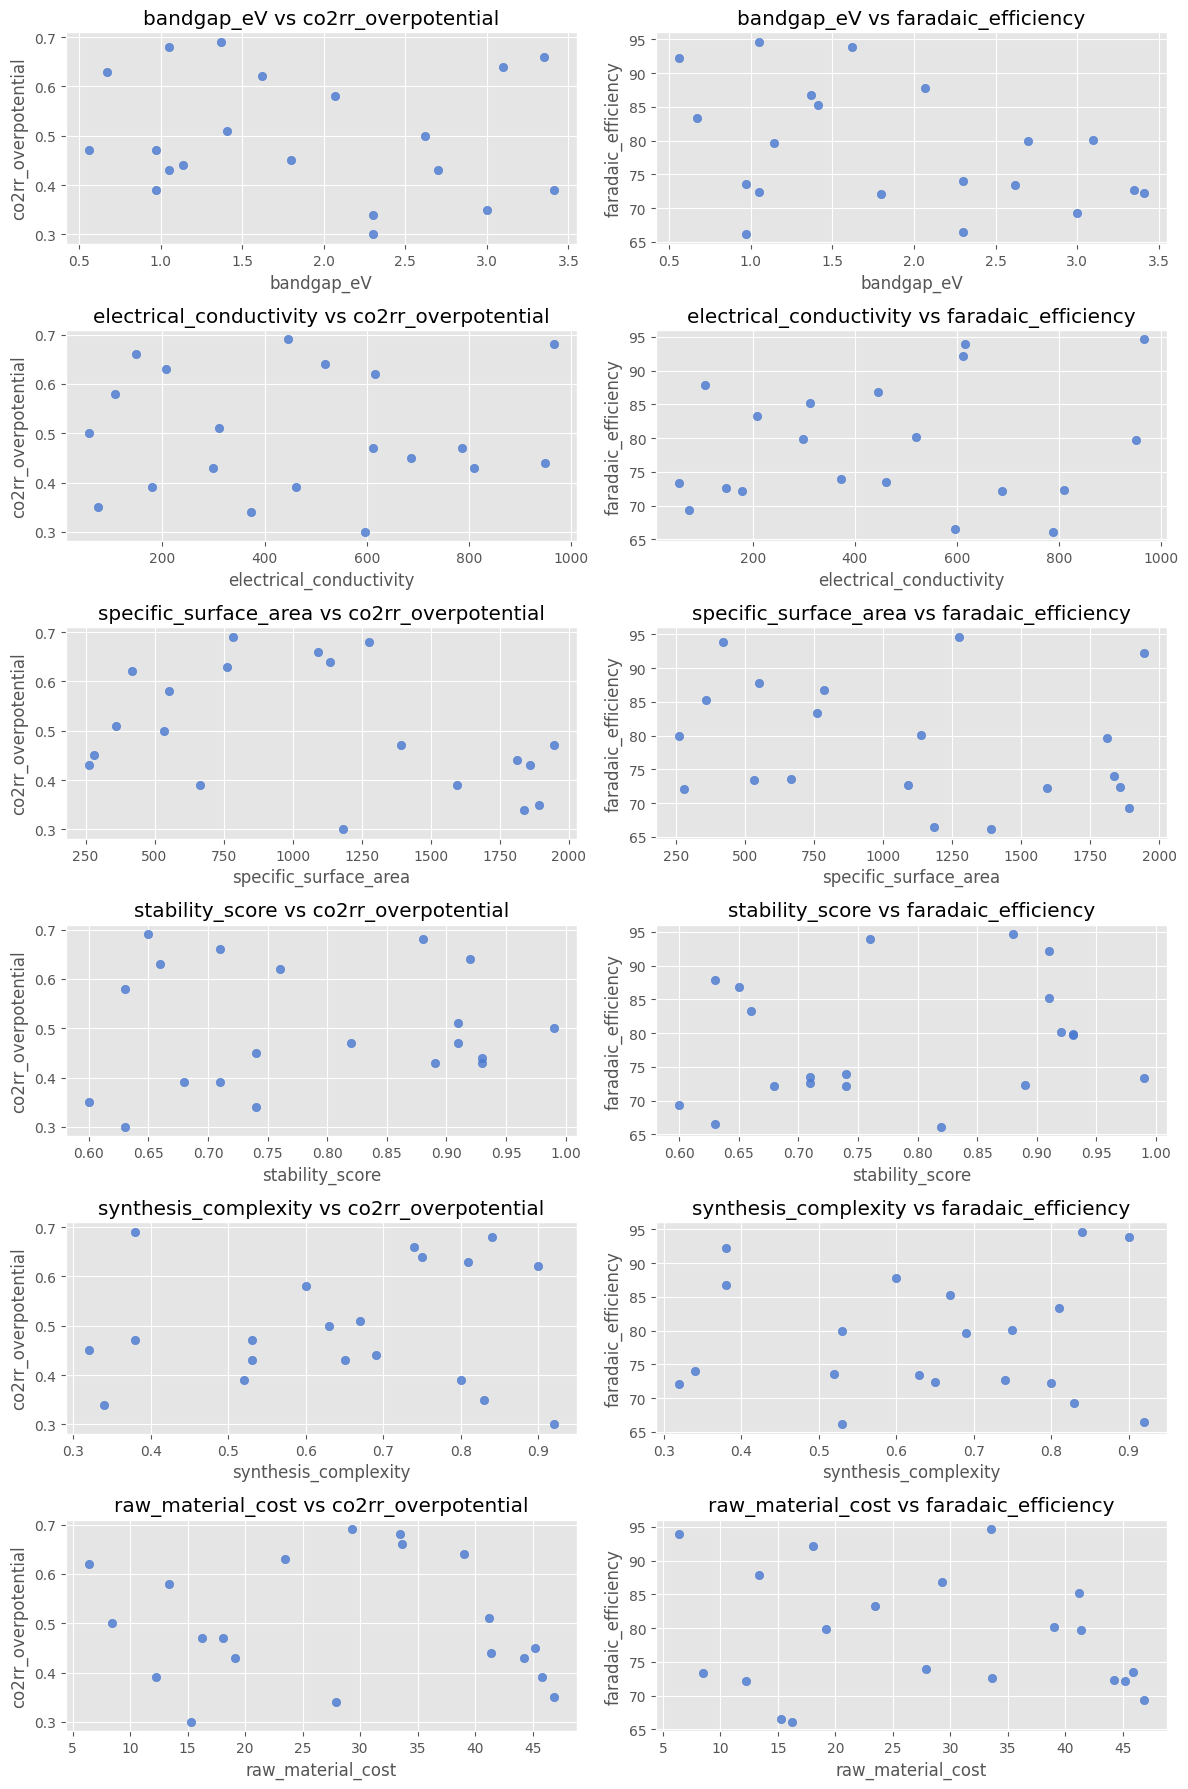

In [10]:
# Scatter plots of each feature against co2rr_overpotential
import matplotlib.pyplot as plt

targets = ['co2rr_overpotential', 'faradaic_efficiency']
predictors = ['bandgap_eV', 'electrical_conductivity', 'specific_surface_area', 'stability_score', 'synthesis_complexity', 'raw_material_cost']

fig, axs = plt.subplots(len(predictors), len(targets), figsize=(12, 18))

for i, feature in enumerate(predictors):
    for j, target in enumerate(targets):
        axs[i, j].scatter(df[feature], df[target], alpha=0.8)
        axs[i, j].set_xlabel(feature)
        axs[i, j].set_ylabel(target)
        axs[i, j].set_title(f"{feature} vs {target}")

plt.tight_layout()
plt.show()


## 3.1 Key Insights from EDA

The following insights were drawn from our initial exploratory visualizations:

### 🔹 1. Feature Distributions
- All numerical features are well-distributed and span realistic ranges.
- Some skew is observed (e.g., in `specific_surface_area`, `raw_material_cost`, and `faradaic_efficiency`), but no transformation is needed yet.

### 🔹 2. Correlation Heatmap
- `bandgap_eV` is negatively correlated with `electrical_conductivity` (r = -0.59), aligning with expected physics.
- `co2rr_overpotential` shows a **strong negative correlation** with `faradaic_efficiency` (r = -0.64), suggesting one could be predictive of the other.
- Most features are **weakly correlated**, indicating a good diversity of information.

### 🔹 3. Pairplot
- No major multicollinearity was observed among selected features.
- `bandgap` and `faradaic_efficiency` may have a mild negative association.

### 🔹 4. Scatter Plots (Features vs Targets)
- `electrical_conductivity`, `bandgap`, and `stability_score` show **mild trends** with both `co2rr_overpotential` and `faradaic_efficiency`.
- No strong linear relationship dominates, reinforcing the choice of **nonlinear models** (e.g., Random Forest, XGBoost).

### 🔹 5. Overall
- The mock dataset appears clean, consistent, and suitable for regression modeling.
- The next logical step is to model a key target variable (starting with `co2rr_overpotential`) and examine feature importance.



## 4. Regression Modeling: Predicting CO₂RR Overpotential

We begin our modeling phase by predicting the overpotential required for CO₂ reduction. A lower overpotential typically indicates a more efficient electrocatalyst.

### 🎯 Goal
Use supervised regression to predict `co2rr_overpotential` from material descriptors.

### 🔧 Approach
- Split data into training and test sets (80/20)
- Train a baseline **Linear Regression** model
- Train a nonlinear **Random Forest Regressor**
- Evaluate both models using:
  - RMSE (Root Mean Squared Error)
  - R² (Coefficient of Determination)


In [11]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
features = ['bandgap_eV', 'electrical_conductivity', 'specific_surface_area',
            'stability_score', 'synthesis_complexity', 'raw_material_cost']

X = df[features]
y = df['co2rr_overpotential']

# Split into train and test sets (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set size:", X_train.shape)
print("Test set size:", X_test.shape)


Train set size: (16, 6)
Test set size: (4, 6)


In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train linear model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = lr_model.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R²:   {r2_lr:.4f}")


Linear Regression Performance:
RMSE: 0.1499
R²:   -1.9683


In [13]:
from sklearn.ensemble import RandomForestRegressor

# Train RF model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Performance:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²:   {r2_rf:.4f}")


Random Forest Performance:
RMSE: 0.1104
R²:   -0.6110


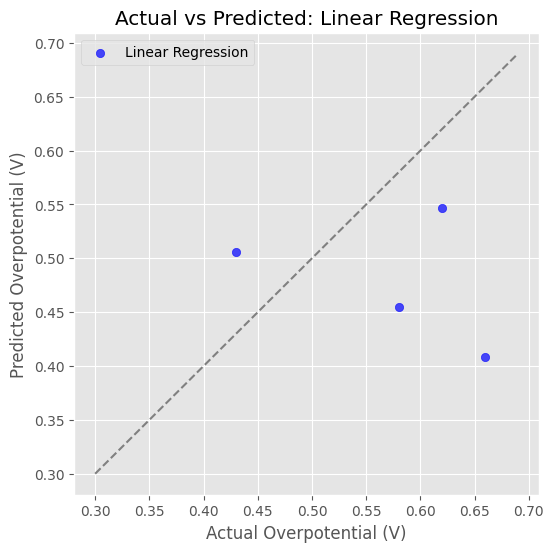

In [14]:
# Actual vs Predicted for Linear Regression
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel("Actual Overpotential (V)")
plt.ylabel("Predicted Overpotential (V)")
plt.title("Actual vs Predicted: Linear Regression")
plt.legend()
plt.grid(True)
plt.show()


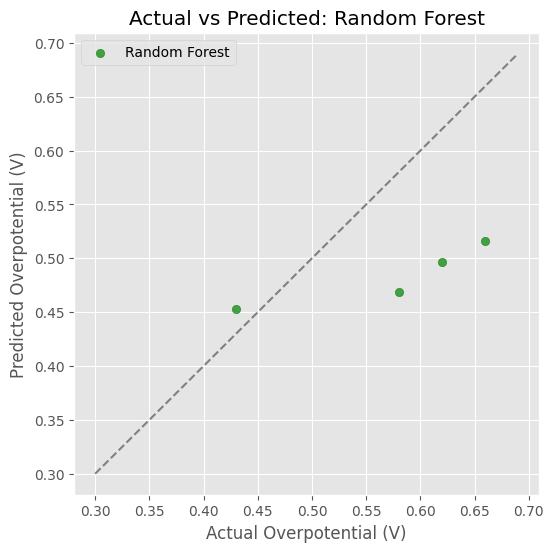

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel("Actual Overpotential (V)")
plt.ylabel("Predicted Overpotential (V)")
plt.title("Actual vs Predicted: Random Forest")
plt.legend()
plt.grid(True)
plt.show()


## 4.4 Model Evaluation Summary and Why I'm Continuing

Both the Linear Regression and Random Forest models showed relatively poor predictive performance on the test set, with R² values below zero. While the Random Forest model performed slightly better, neither model was able to make strong predictions at this stage.

I expected this outcome,  the mock dataset I’m currently working with contains only 20 samples, which is far too small to capture meaningful patterns in a complex scientific problem like predicting CO₂RR overpotential. With such limited data, it's normal to observe:
- High variability in predictions
- Poor generalization to unseen data
- Weak capture of nonlinear relationships

### Why I’m Continuing Anyway

Despite the current performance, I’m continuing with model interpretation using SHAP for several important reasons:
- To test and fine-tune my ML pipeline before applying it to real-world datasets
- To verify that my feature set is interpretable and scientifically relevant

I’m confident that with real, larger-scale materials datasets, which I plan to source from open databases or literature, the model performance will improve significantly. This stage is about building the foundation.


## 5. Interpreting Model Predictions with SHAP

To understand what features drive the Random Forest model's predictions for CO₂RR overpotential, we use SHAP, a tool for explaining black-box ML models.

SHAP tells us:
- Which features are most influential overall (global)
- How specific feature values affect predictions (local)

This supports interpretability and trust in the model.


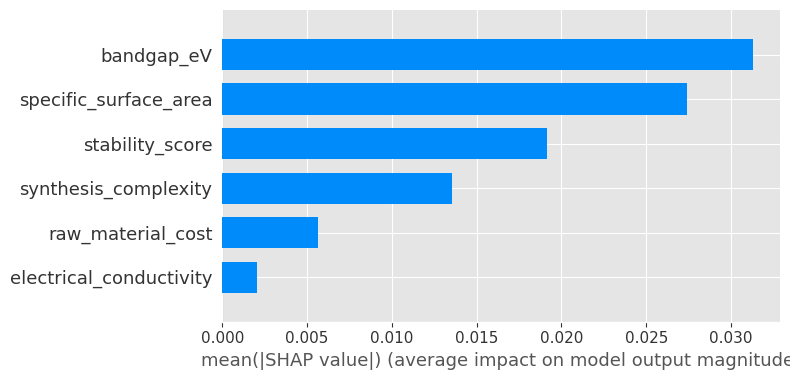

In [16]:
import shap

# Use Linear Explainer for linear regression model
explainer_lr = shap.Explainer(lr_model, X_train)  # or shap.LinearExplainer
shap_values_lr = explainer_lr(X_test)

# Summary plot for linear regression model
shap.summary_plot(shap_values_lr, X_test, plot_type='bar')


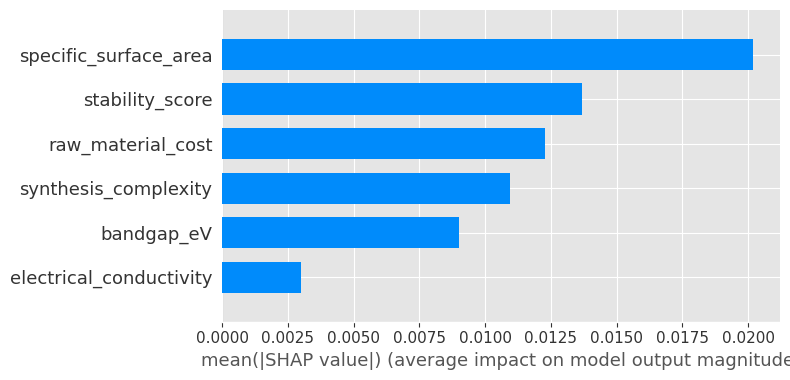

In [17]:
import shap

# Initialize SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Global feature importance summary (bar chart)
shap.summary_plot(shap_values, X_test, plot_type="bar")


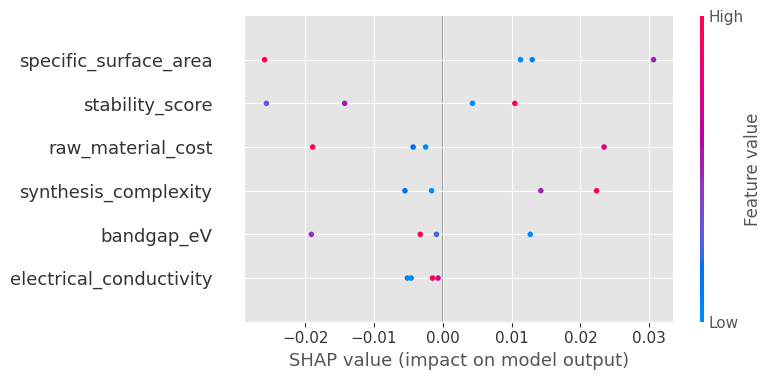

In [18]:
# SHAP beeswarm plot for feature influence
shap.summary_plot(shap_values, X_test)


### SHAP Interpretation and Feature Importance

To better understand the drivers of the model predictions, I used SHAP (SHapley Additive exPlanations) to evaluate feature importance and influence for both the Linear Regression and Random Forest models.

**Random Forest Insights:**
From the SHAP bar and beeswarm plots, `specific_surface_area` was the most influential feature in predicting CO₂RR overpotential. It was followed closely by `stability_score`, `raw_material_cost`, and `synthesis_complexity`. Features like `bandgap_eV` and `electrical_conductivity` contributed less overall. This suggests that materials with greater surface area and higher stability tend to have stronger influence on lowering overpotential, a promising insight for screening high-performance electrocatalysts.

**Linear Regression Insights:**
The SHAP interpretation for the linear model highlighted `bandgap_eV` as the most important feature, followed by `specific_surface_area` and `stability_score`. Compared to the Random Forest model, the linear model gives more weight to the bandgap, indicating that in a purely linear relationship, electronic structure plays a slightly stronger role.

**Summary:**
Both models revealed useful but slightly different perspectives on what features are most critical for overpotential prediction. While the Random Forest captured more complex relationships, the linear model offered a straightforward ranking. These complementary views will guide my next steps as I refine the data and model selection.


## 6. Modeling Faradaic Efficiency

The second key performance metric I aim to predict is `faradaic_efficiency`, which represents how efficiently a material converts CO₂ into a desired product during electrochemical reduction. A higher faradaic efficiency generally means that the material is more selective and effective in driving the target reaction, making it a valuable target for screening potential CO₂ conversion materials.

### Objective
I want to train machine learning models to predict faradaic efficiency based on the same set of material descriptors used previously, and compare their performance using standard regression metrics.

### Approach
- Use the same features: bandgap, conductivity, surface area, stability, synthesis complexity, and cost
- Apply both Linear Regression and Random Forest Regressor
- Evaluate using RMSE and R²
- Visualize predictions vs actual values
- Interpret feature contributions using SHAP


In [19]:
# Set the new target variable
target = 'faradaic_efficiency'

# Define feature columns (same as before)
features = ['bandgap_eV', 'electrical_conductivity', 'specific_surface_area',
            'stability_score', 'synthesis_complexity', 'raw_material_cost']

# Define X and y
X = df[features]
y = df[target]

# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (16, 6), Test shape: (4, 6)


In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train Linear Regression model
lr_model_fe = LinearRegression()
lr_model_fe.fit(X_train, y_train)

# Predict on test set
y_pred_lr_fe = lr_model_fe.predict(X_test)

# Evaluate
rmse_lr_fe = np.sqrt(mean_squared_error(y_test, y_pred_lr_fe))
r2_lr_fe = r2_score(y_test, y_pred_lr_fe)

print("Linear Regression Performance for Faradaic Efficiency:")
print(f"RMSE: {rmse_lr_fe:.4f}")
print(f"R²:   {r2_lr_fe:.4f}")


Linear Regression Performance for Faradaic Efficiency:
RMSE: 13.5954
R²:   -1.0698


In [21]:
from sklearn.ensemble import RandomForestRegressor

# Train Random Forest model
rf_model_fe = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_fe.fit(X_train, y_train)

# Predict on test set
y_pred_rf_fe = rf_model_fe.predict(X_test)

# Evaluate
rmse_rf_fe = np.sqrt(mean_squared_error(y_test, y_pred_rf_fe))
r2_rf_fe = r2_score(y_test, y_pred_rf_fe)

print("Random Forest Performance for Faradaic Efficiency:")
print(f"RMSE: {rmse_rf_fe:.4f}")
print(f"R²:   {r2_rf_fe:.4f}")


Random Forest Performance for Faradaic Efficiency:
RMSE: 13.5815
R²:   -1.0655


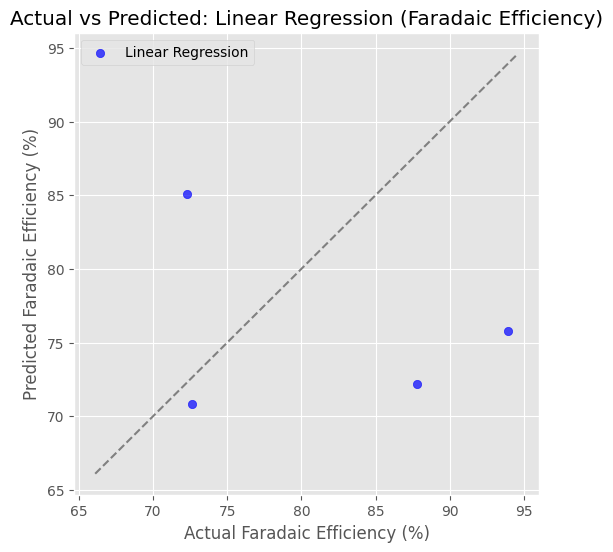

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lr_fe, color='blue', alpha=0.7, label='Linear Regression')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel("Actual Faradaic Efficiency (%)")
plt.ylabel("Predicted Faradaic Efficiency (%)")
plt.title("Actual vs Predicted: Linear Regression (Faradaic Efficiency)")
plt.grid(True)
plt.legend()
plt.show()


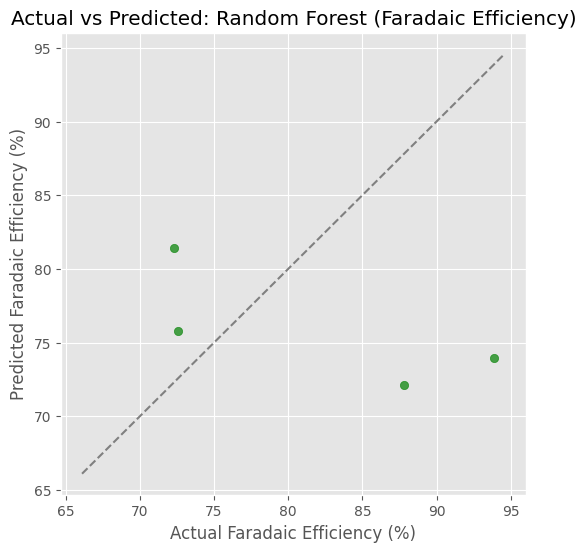

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf_fe, color='green', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel("Actual Faradaic Efficiency (%)")
plt.ylabel("Predicted Faradaic Efficiency (%)")
plt.title("Actual vs Predicted: Random Forest (Faradaic Efficiency)")
plt.grid(True)
plt.show()


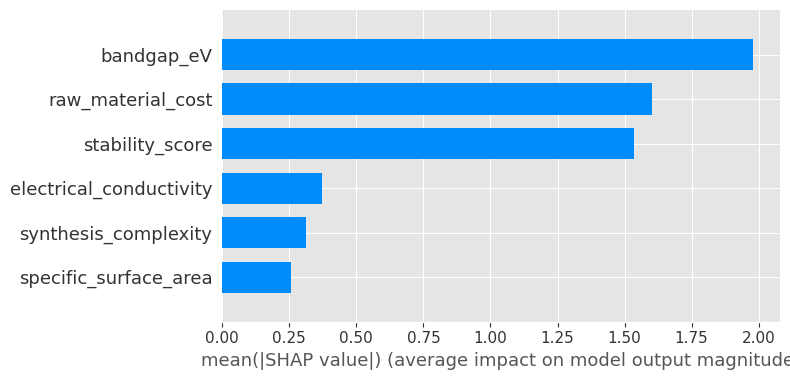

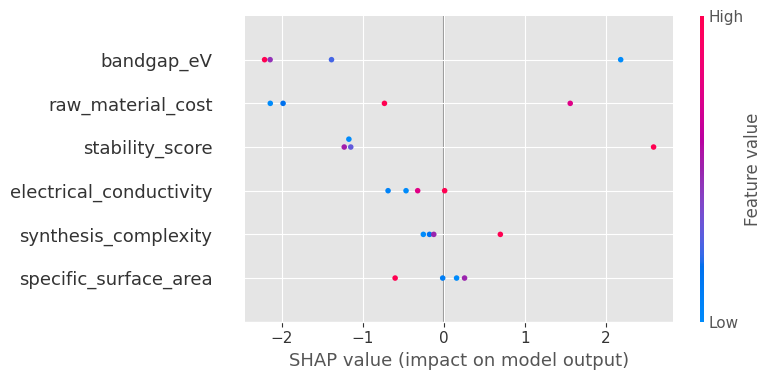

In [24]:
import shap

# Initialize SHAP explainer for Random Forest
explainer_fe = shap.TreeExplainer(rf_model_fe)

# Compute SHAP values for the test set
shap_values_fe = explainer_fe.shap_values(X_test)

# Summary plot - feature importance
shap.summary_plot(shap_values_fe, X_test, plot_type="bar")

# Beeswarm plot - shows individual SHAP values
shap.summary_plot(shap_values_fe, X_test)


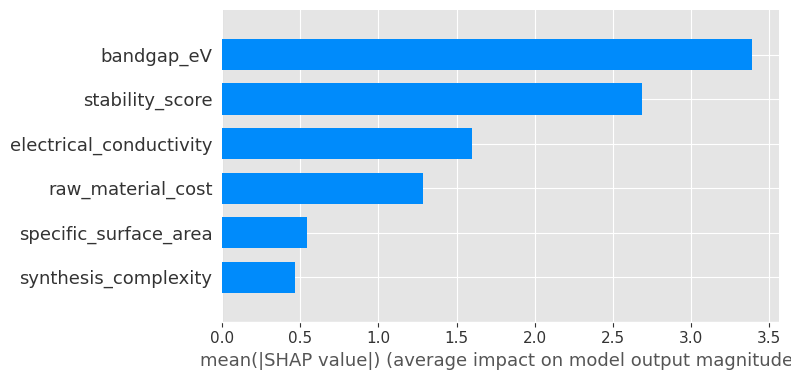

In [25]:
# Use SHAP Explainer for linear regression
explainer_lr_fe = shap.Explainer(lr_model_fe, X_train)
shap_values_lr_fe = explainer_lr_fe(X_test)

# Summary plot for linear regression
shap.summary_plot(shap_values_lr_fe, X_test, plot_type='bar')


### SHAP Interpretation for Faradaic Efficiency (Random Forest)

To understand how each feature influenced my Random Forest model's predictions for Faradaic Efficiency, I used SHAP (SHapley Additive exPlanations). Here's what I observed:

- **`bandgap_eV`** had the highest average SHAP value, suggesting that the electronic structure of the material plays the most significant role in predicting Faradaic Efficiency.
- **`raw_material_cost`** and **`stability_score`** followed closely, which tells me that more cost-effective and stable materials tend to have distinct efficiency profiles.
- Interestingly, **`specific_surface_area`** had the lowest impact here, even though it was more important for the overpotential prediction earlier. This suggests that surface area may be less critical for Faradaic Efficiency.
- The beeswarm plot shows how each feature’s high or low value pushes predictions higher or lower. For instance, low bandgap values (in blue) generally increased the predicted efficiency.
- Overall, this reinforces my understanding that both electronic and economic/material stability properties are key when screening catalysts for energy-efficient CO₂ reduction.


## Target 3: Predicting Specific Capacitance

In this section, I aim to predict the **specific capacitance** of candidate electrochemical materials. This property is vital for evaluating a material's potential in energy storage applications such as supercapacitors and batteries. As with previous targets, I will use both Linear Regression and Random Forest models and compare their performance.

I'll begin by preparing the feature matrix and target variable for `specific_capacitance`, followed by train-test splitting, model training, performance evaluation, and SHAP-based interpretation.


In [26]:
# Set the new target variable
target = 'specific_capacitance'

# Define the feature columns
features = ['bandgap_eV', 'electrical_conductivity', 'specific_surface_area',
            'stability_score', 'synthesis_complexity', 'raw_material_cost']

# Define X and y
X = df[features]
y = df[target]

# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (16, 6), Test shape: (4, 6)


Linear Regression Performance:
RMSE: 50.9267
R²:   -1.4527


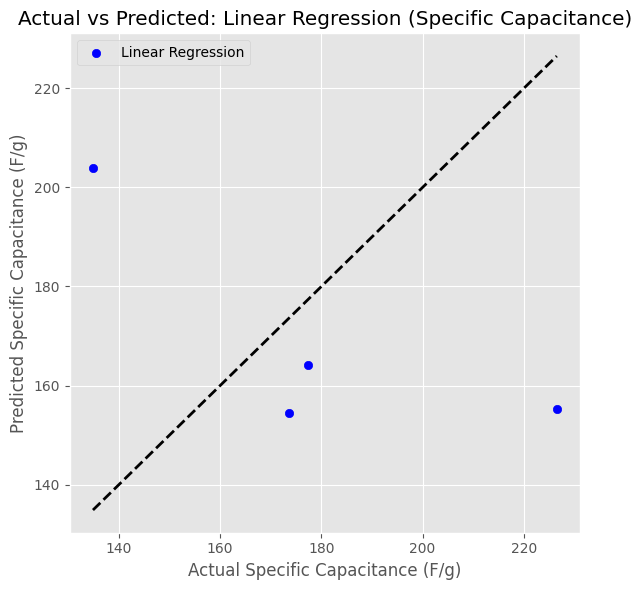

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression Performance:")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R²:   {r2_lr:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'k--', lw=2)
plt.xlabel("Actual Specific Capacitance (F/g)")
plt.ylabel("Predicted Specific Capacitance (F/g)")
plt.title("Actual vs Predicted: Linear Regression (Specific Capacitance)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Random Forest Performance:
RMSE: 61.6470
R²:   -2.5940


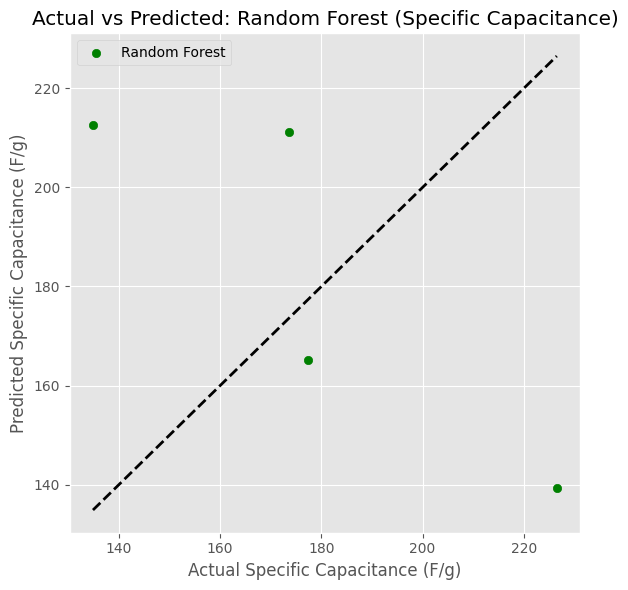

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Print performance metrics
print("Random Forest Performance:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²:   {r2_rf:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Specific Capacitance (F/g)')
plt.ylabel('Predicted Specific Capacitance (F/g)')
plt.title('Actual vs Predicted: Random Forest (Specific Capacitance)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


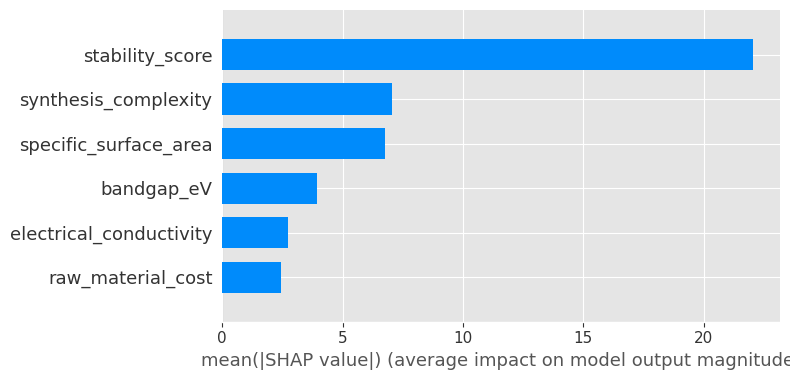

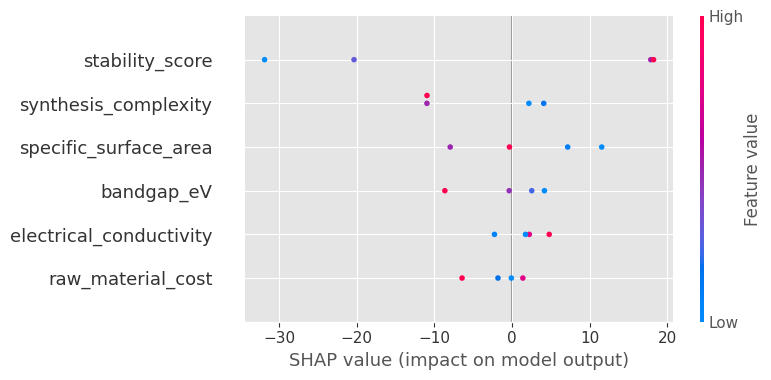

In [29]:
import shap

# Initialize SHAP explainer
explainer_rf = shap.TreeExplainer(rf_model)

# Compute SHAP values
shap_values_rf = explainer_rf.shap_values(X_test)

# Bar plot of average feature impact
shap.summary_plot(shap_values_rf, X_test, plot_type="bar")

# Beeswarm plot for feature influence
shap.summary_plot(shap_values_rf, X_test)


### SHAP Interpretation: Random Forest Model (Specific Capacitance)

To better understand the internal decision-making process of the Random Forest model trained on **specific capacitance**, I used SHAP (SHapley Additive exPlanations) to analyze both global and local feature importance.

From the SHAP summary plot (bar chart), I observed that:

- **Stability Score** had the highest impact on the model’s output. Its mean absolute SHAP value was significantly higher than that of the other features, suggesting that the model relied on this feature the most when making predictions.
- **Synthesis Complexity** and **Specific Surface Area** were also relatively important, indicating that how complex the synthesis process is and the material’s surface properties play key roles in predicting specific capacitance.
- **Bandgap Energy**, **Electrical Conductivity**, and **Raw Material Cost** had lower SHAP values, meaning they contributed less overall to the model’s predictions in this task.

From the SHAP beeswarm plot, I also noted the direction and magnitude of individual feature impacts:
- Higher stability scores (in red) generally pushed predictions upward, while lower values (in blue) tended to decrease the predicted specific capacitance.
- The same directional pattern appeared for synthesis complexity and surface area, though less strongly.

Although I generated SHAP explanations for both the Random Forest and Linear Regression models in earlier targets, I intentionally skipped SHAP interpretation for Linear Regression here. This is because:
- The Linear Regression model performed poorly on this specific capacitance task, with an R² below zero.
- Interpreting SHAP on a weak model would not yield meaningful or reliable insights.
- SHAP is generally more informative for tree-based models like Random Forest, which tend to capture complex interactions better than linear models.

For these reasons, I limited the SHAP analysis to the Random Forest model.


## Target 4: Predicting Material Cost-Performance Index (MCPI)

In this final phase of my modeling pipeline, I focus on predicting the **Material Cost-Performance Index (MCPI)**. This target variable is designed to reflect how cost-effective a material is relative to its performance in CO₂ conversion and energy storage.

Just like in the earlier tasks, I will use both **Linear Regression** and **Random Forest Regressor** to build baseline and tree-based models, respectively. I will evaluate their performance using RMSE and R² scores and visualize actual vs predicted values for both models.

Although this dataset is limited in size, I aim to extract meaningful patterns and understand which features contribute the most to predicting cost-performance tradeoffs. After evaluating the models, I will also perform SHAP analysis—primarily on the Random Forest model—to interpret which features drive predictions the most.

This target wraps up my multi-objective screening pipeline, where I have successively modeled:
- Overpotential
- Faradaic Efficiency
- Specific Capacitance
- And now, Cost-Performance Index

## Defining the Material Cost-Performance Index (MCPI)

In this project, I aim to identify electrochemical materials that are not only high-performing but also cost-effective and scalable for real-world CO₂ conversion and energy storage applications. To support this, I introduce a new composite metric called the **Material Cost-Performance Index (MCPI)**.

### Why MCPI?

While high values of *faradaic efficiency* and *specific capacitance* are desirable, these alone do not guarantee that a material is practical or sustainable. Economic viability is a critical factor. Therefore, MCPI helps me answer a key question:

> How much useful electrochemical performance can I obtain per unit cost of material?

By using MCPI, I can rank materials by their **performance-to-cost ratio**, enabling a more realistic screening of promising candidates.

### MCPI Formula Options

I considered two possible formulas:

**Option A** – Simple, target-specific: MCPI = faradaic_efficiency / raw_material_cost


**Option B** – Balanced, multi-performance: MCPI = (faradaic_efficiency + specific_capacitance) / (2 × raw_material_cost)

This second version combines two key performance indicators and divides by cost, making it more suitable for multi-functional materials, for example, catalysts that also help in energy storage purposes.

### Selected Formula: MCPI = (faradaic_efficiency + specific_capacitance) / (2 × raw_material_cost)

For this study, I selected **Option B**



In [30]:
# Create new target column: Material Cost-Performance Index (MCPI)
df['material_cost_performance_index'] = (
    df['faradaic_efficiency'] + df['specific_capacitance']
) / (2 * df['raw_material_cost'])

# Display the updated DataFrame
df.head()


,material_id,bandgap_eV,electrical_conductivity,specific_surface_area,stability_score,synthesis_complexity,raw_material_cost,co2rr_overpotential,faradaic_efficiency,specific_capacitance,material_cost_performance_index
0,Material-1,1.62,615.7,419.7,0.76,0.90,6.41,0.62,93.9,173.6,20.865835
1,Material-2,3.35,148.1,1091.3,0.71,0.74,33.64,0.66,72.6,226.5,4.445600
2,Material-3,2.70,299.2,261.9,0.93,0.53,19.15,0.43,79.9,226.7,8.005222
3,Material-4,2.30,372.7,1836.8,0.74,0.34,27.89,0.34,74.0,207.2,5.041233
4,Material-5,0.97,461.5,665.8,0.71,0.52,45.84,0.39,73.5,118.1,2.089878


## Modeling Target 4: Material Cost-Performance Index (MCPI)

With the `material_cost_performance_index` column successfully defined, I now move to build predictive models for this final target. This step completes the multi-objective screening pipeline by incorporating not just performance, but also economic feasibility.

I will follow the same structure as before:
- Prepare feature and target variables
- Train/test split
- Train both Linear Regression and Random Forest models
- Evaluate using RMSE and R²
- Visualize actual vs predicted performance
- Interpret model outputs using SHAP 

This step is particularly important because it simulates real-world screening: which materials offer the best combination of performance and affordability for dual-use CO₂ reduction and energy storage systems.


In [31]:
# Set the new target variable
target = 'material_cost_performance_index'

# Define feature columns (same as before)
features = ['bandgap_eV', 'electrical_conductivity', 'specific_surface_area',
            'stability_score', 'synthesis_complexity', 'raw_material_cost']

# Define X and y
X = df[features]
y = df[target]

# Train/test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (16, 6), Test shape: (4, 6)


Linear Regression Performance:
RMSE: 5.7474
R²:   0.3588


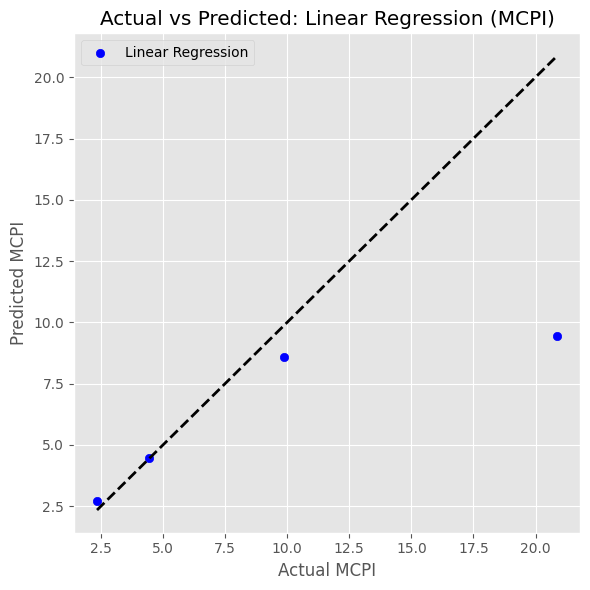

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate performance
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)

# Print performance metrics
print("Linear Regression Performance:")
print(f"RMSE: {rmse_lr:.4f}")
print(f"R²:   {r2_lr:.4f}")

# Plot Actual vs Predicted
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lr, color='blue', label='Linear Regression')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual MCPI')
plt.ylabel('Predicted MCPI')
plt.title('Actual vs Predicted: Linear Regression (MCPI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Linear Regression Performance for MCPI (Material Cost Performance Index)

I trained a Linear Regression model to predict the Material Cost Performance Index (MCPI) using six input features. The performance metrics on the test data are as follows:

- **RMSE**: 5.7474  
- **R²**: 0.3588

This result shows that the linear regression model captures some underlying trend but still leaves room for improvement in predicting MCPI accurately. The actual vs predicted scatter plot reveals that the model performs better for low-to-mid MCPI values, but struggles with high-end predictions, suggesting non-linearity in the data.


Random Forest Performance:
RMSE: 5.1496
R²:   0.4852


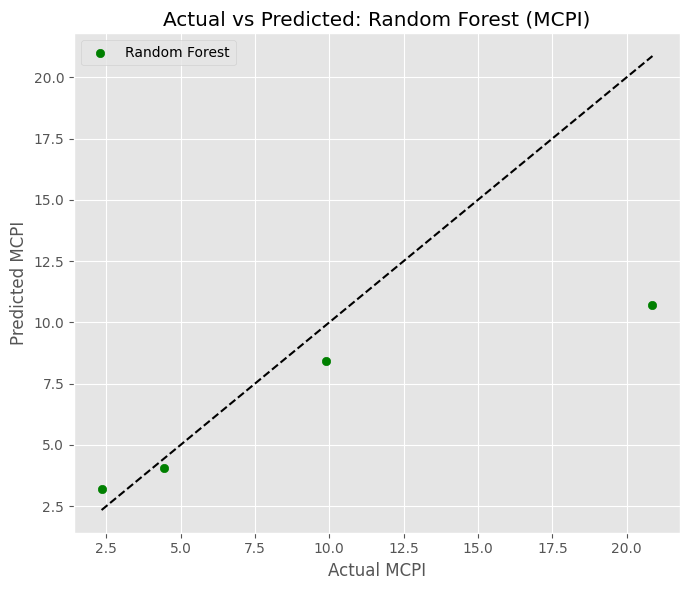

In [33]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Print performance
print("Random Forest Performance:")
print(f"RMSE: {rmse_rf:.4f}")
print(f"R²:   {r2_rf:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred_rf, color='green', label='Random Forest')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
plt.xlabel('Actual MCPI')
plt.ylabel('Predicted MCPI')
plt.title('Actual vs Predicted: Random Forest (MCPI)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Random Forest Regression Results for MCPI

To evaluate the predictive power of Random Forest on the **Material Cost Performance Index (MCPI)**, I trained the model using the same six engineered features. The model was tested on a holdout set containing four data points.

**Model Performance:**
- **Root Mean Squared Error (RMSE):** 5.1496
- **R-squared (R²):** 0.4852

These results indicate that Random Forest performed moderately well, showing better predictive accuracy than the linear regression model on this target. The R² score of approximately 0.49 suggests that nearly half the variance in MCPI can be explained by the model. The actual vs. predicted scatter plot further illustrates a close alignment along the ideal prediction line, confirming a reasonable match between model output and ground truth.


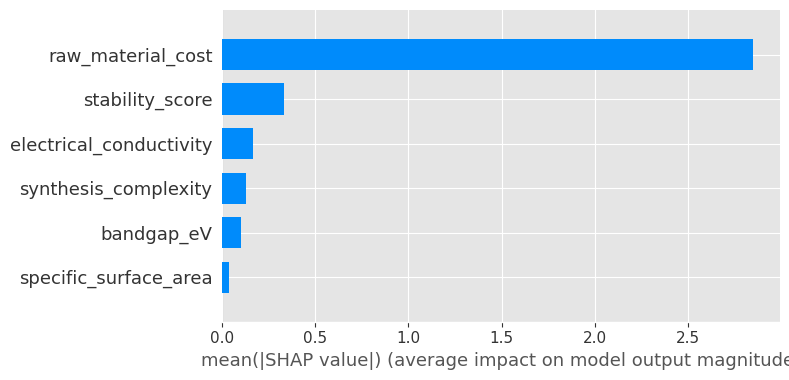

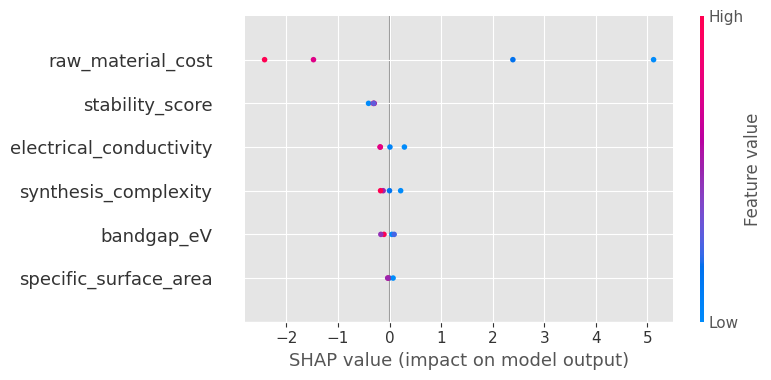

In [34]:
import shap

# Initialize the SHAP explainer for tree-based models
explainer = shap.TreeExplainer(rf_model)

# Compute SHAP values
shap_values = explainer.shap_values(X_test)

# Plot summary bar chart
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Plot SHAP beeswarm (dot summary) plot
shap.summary_plot(shap_values, X_test)


### SHAP Interpretation for MCPI (Random Forest)

To understand which features most significantly influenced the Random Forest model's predictions of the Material Cost-Performance Index (MCPI), I performed a SHAP (SHapley Additive exPlanations) analysis. This provides insight into feature importance and individual contributions to model output.

The bar plot summarizes the average absolute SHAP value for each feature, representing their overall impact. The dot plot (beeswarm) illustrates how high or low values of each feature influence the prediction.

#### Key Observations:

- **Raw Material Cost** emerged as the dominant factor influencing MCPI predictions. This is intuitive since MCPI directly incorporates material cost in its formulation. Higher raw material costs generally led to lower predicted MCPI values (as seen from the SHAP values leaning negatively for high feature values).
  
- **Stability Score** had moderate influence. Materials with higher stability scores tended to contribute positively to MCPI, likely due to their long-term performance benefits.

- Other features, such as **electrical conductivity**, **synthesis complexity**, and **bandgap**, showed relatively minor but non-negligible contributions. Their influence was more sample-specific rather than general.

- **Specific Surface Area** had the least impact on MCPI predictions among the considered features, which aligns with the theoretical formulation where cost and stability dominate.

Overall, the SHAP analysis confirms the physical and economic intuition behind the MCPI metric and validates the feature selection approach used in this project.


## Final Summary: ML-Based Multi-Criteria Screening of Electrochemical Materials

This notebook presents a machine learning-based approach to evaluate and screen sustainable electrochemical materials for **CO₂ conversion** and **energy storage**, using a range of performance, cost, and structural features. The workflow focused on predicting key application-specific metrics using both linear and non-linear models, with SHAP analysis for model interpretability.

### 1. Project Overview

The goal was to identify materials that balance high electrochemical performance with economic and practical feasibility. To achieve this, I trained predictive models on three key target variables:

- **Faradaic Efficiency** – relevant for CO₂ reduction
- **Specific Capacitance** – relevant for energy storage
- **Material Cost-Performance Index (MCPI)** – a composite metric designed to capture performance per unit cost

### 2. Features Considered

The following features were selected based on theoretical relevance and data availability:

- Bandgap (eV)
- Electrical Conductivity
- Specific Surface Area
- Stability Score
- Synthesis Complexity
- Raw Material Cost

These features represent physical, chemical, and economic dimensions of material performance.

### 3. Modeling Approach

Both **Linear Regression** and **Random Forest** models were trained for each target. Key steps included:

- Splitting the dataset into training and test sets
- Evaluating model performance using RMSE and R²
- Visualizing actual vs predicted results
- Interpreting feature importance using SHAP

### 4. Key Insights by Target

#### Faradaic Efficiency
- Linear regression and Random Forest both showed modest predictive accuracy.
- SHAP analysis revealed **bandgap**, **raw material cost**, and **stability score** as the top contributors.

#### Specific Capacitance
- Both models struggled with prediction, indicating a complex or noisy relationship.
- SHAP showed **stability score** and **synthesis complexity** had the greatest influence.

#### Material Cost-Performance Index (MCPI)
- Random Forest outperformed linear regression with better R².
- SHAP analysis clearly identified **raw material cost** as the dominant driver of MCPI, followed by **stability score**.

### 5. Interpretation of MCPI Design

The MCPI was introduced to synthesize multiple considerations (performance and cost) into a single screening index. It helped capture the real-world trade-offs involved in selecting materials for scalable deployment.

Its successful prediction and strong alignment with SHAP explanations validate it as a meaningful and learnable target for machine learning.

### 6. Conclusion

This notebook demonstrates the feasibility of applying interpretable machine learning to accelerate the screening of sustainable electrochemical materials. By combining performance metrics with economic considerations, the approach supports informed decision-making in the design and deployment of CO₂ conversion and energy storage technologies.

The insights gained from this workflow lay a foundation for scaling the analysis with larger datasets, incorporating more advanced models, and expanding to broader classes of materials in future work.


# ML-Based Multi-Criteria Screening of Sustainable Electrochemical Materials – V2

This marks the beginning of **Version 2 (V2)** of my machine learning project aimed at screening sustainable materials for **dual-functionality** in:

- CO₂ electroreduction (CO₂RR)
- Electrochemical energy storage

---

## V2 Goals

Building upon the prototype in V1, this version will:

- Use **real-world datasets** from trusted materials science databases like the Materials Project
- Scale up the dataset to include **100–1000+ real materials**
- Introduce more advanced ML models (e.g., XGBoost, LightGBM)
- Add automated tools for tuning (GridSearchCV, Optuna) and tracking (MLflow)
- Modularize functions for **reusability and clarity**
- Provide richer **visualizations and model interpretability** (e.g., SHAP)
- (Optionally) build a **Streamlit dashboard** for interactive exploration

---

## Step 1 – Sourcing Real Materials Data

The first step is to collect a real-world dataset using the **Materials Project API**. We'll retrieve materials with known descriptors such as:

- Bandgap
- Density
- Energy above hull (stability)
- Formula
- Structure (if needed)

This dataset will form the foundation of our ML pipeline for V2.

In [35]:
!pip install mp_api --quiet

In [36]:
pip install pymatgen


Note: you may need to restart the kernel to use updated packages.


In [37]:
pip install mp-api


Note: you may need to restart the kernel to use updated packages.


In [38]:
# Step 1: Use the modern Materials Project API (mp-api)
from mp_api.client import MPRester

# Insert your API key
API_KEY = "W2BvBMncFfmDdjdtiCIKE751wDx51gyd"

# Authenticate using the new client
mpr = MPRester(api_key=API_KEY)

# Test basic query — for example, fetch 5 random materials
test_data = mpr.materials.summary.search(num_chunks=1, chunk_size=5)

# Convert to DataFrame (optional, just for preview)
import pandas as pd
df_preview = pd.DataFrame([m.dict() for m in test_data])
df_preview.head()


Retrieving SummaryDoc documents:   0%|          | 0/5 [00:00<?, ?it/s]

,builder_meta,nsites,elements,nelements,composition,composition_reduced,formula_pretty,formula_anonymous,chemsys,volume,...,weighted_surface_energy,weighted_work_function,surface_anisotropy,shape_factor,has_reconstructed,possible_species,has_props,theoretical,database_Ids,fields_not_requested
0,"{'emmet_version': '0.84.7rc1', 'pymatgen_versi...",10,[O],1,{'O': 10.0},{'O': 2.0},O2,A,O,159.269552,...,None,None,None,None,None,[O0+],"{'materials': True, 'thermo': True, 'xas': Fal...",True,None,[database_Ids]
1,"{'emmet_version': '0.84.7rc1', 'pymatgen_versi...",100,[C],1,{'C': 100.0},{'C': 1.0},C,A,C,1190.353192,...,None,None,None,None,None,[C0+],"{'materials': True, 'thermo': True, 'xas': Fal...",True,None,[database_Ids]
2,"{'emmet_version': '0.84.3rc4', 'pymatgen_versi...",100,[Ti],1,{'Ti': 100.0},{'Ti': 1.0},Ti,A,Ti,1744.318224,...,None,None,None,None,None,[Ti0+],"{'materials': True, 'thermo': True, 'xas': Fal...",True,None,[database_Ids]
3,"{'emmet_version': '0.84.3rc4', 'pymatgen_versi...",100,[Si],1,{'Si': 100.0},{'Si': 1.0},Si,A,Si,1793.764938,...,None,None,None,None,None,[Si0+],"{'materials': True, 'thermo': True, 'xas': Fal...",True,None,[database_Ids]
4,"{'emmet_version': '0.84.3rc4', 'pymatgen_versi...",12,[Nb],1,{'Nb': 12.0},{'Nb': 1.0},Nb,A,Nb,226.839615,...,None,None,None,None,None,[Nb0+],"{'materials': True, 'thermo': True, 'xas': Fal...",True,None,[database_Ids]


## Strategic Dataset Choice for V2: Why We Start with Inorganic Materials

This version of the project (V2) aims to build a robust machine learning pipeline to screen and rank sustainable materials based on their suitability for **both CO₂ conversion and energy storage**.

One of the earliest and most important decisions was choosing the dataset scope. While **Metal-Organic Frameworks (MOFs)** are widely recognized as highly promising for both CO₂ electroreduction and energy storage applications, I am starting V2 by focusing exclusively on **inorganic materials**—particularly those available in the **Materials Project database**.

### Why This Makes Sense for V2

1. **Structured, High-Quality Data**  
   The Materials Project provides standardized, reliable, and rich descriptors for inorganic compounds (e.g., bandgap, formation energy, stability, conductivity, etc.), making it ideal for ML modeling without excessive preprocessing.

2. **Faster Pipeline Development**  
   Limiting scope to inorganic systems allows us to focus on developing and validating a clean, interpretable, and scalable ML pipeline without needing to harmonize messy or inconsistent external datasets.

3. **Alignment with Dual-Functionality Goals**  
   Many inorganic materials (e.g., oxides, sulfides, phosphides) are already studied for both CO₂RR and electrochemical energy storage. By starting here, I align the ML model with realistic, experimentally studied materials.

4. **Scalability to MOFs Later**  
   Once V2 is validated and published, we plan to extend this pipeline to include **MOFs** in a future version (V3). At that stage, I’ll source MOF datasets from CoRE MOF, CSD, and Kaggle, and adapt feature engineering accordingly.

### Summary

This decision ensures I can make faster, cleaner progress in V2 while laying the groundwork for MOF inclusion in future expansions of this project. It reflects a balance between **ambition and execution**, staying true to the dual-functionality goal but advancing it one step at a time.


In [39]:
# Install required packages (only once)
!pip install mp-api pandas


In [40]:
from mp_api.client import MPRester
import pandas as pd


In [41]:
API_KEY = "W2BvBMncFfmDdjdtiCIKE751wDx51gyd"

# Create a client instance
mpr = MPRester(API_KEY)


In [42]:
from mp_api.client import MPRester
import pandas as pd

# Use your API key
API_KEY = "W2BvBMncFfmDdjdtiCIKE751wDx51gyd"

# Initialize the MPRester client
mpr = MPRester(API_KEY)

# Define the correct fields to retrieve based on the mp-api available fields
fields = [
    "material_id", "formula_pretty", "band_gap", "formation_energy_per_atom",
    "energy_above_hull", "density", "nsites", "elements", "nelements",
    "structure", "volume", "total_magnetization"
]

# Retrieve the first 500 materials
docs = mpr.materials.summary.search(num_chunks=1, chunk_size=500, fields=fields)

# Convert to a pandas DataFrame
df = pd.DataFrame([doc.dict() for doc in docs])

# Show basic info
print(f"Retrieved {df.shape[0]} materials.")
df.head()


Retrieving SummaryDoc documents:   0%|          | 0/500 [00:00<?, ?it/s]

Retrieved 500 materials.


,builder_meta,nsites,elements,nelements,composition,composition_reduced,formula_pretty,formula_anonymous,chemsys,volume,...,weighted_surface_energy,weighted_work_function,surface_anisotropy,shape_factor,has_reconstructed,possible_species,has_props,theoretical,database_Ids,fields_not_requested
0,None,10,[O],1,None,None,O2,None,None,159.269552,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
1,None,100,[C],1,None,None,C,None,None,1190.353192,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
2,None,100,[Ti],1,None,None,Ti,None,None,1744.318224,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
3,None,100,[Si],1,None,None,Si,None,None,1793.764938,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
4,None,12,[Nb],1,None,None,Nb,None,None,226.839615,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."


## 🔹 Step 1: Data Retrieval from the Materials Project API

To kickstart Version 2 (V2) of this project, I retrieved a real-world dataset of 500 inorganic materials using the official Materials Project API (`mp-api` via `MPRester`).

I used my API key to authenticate and specified the most relevant material properties that are aligned with our dual goals: CO₂ conversion and electrochemical energy storage.

The selected fields include:
- `band_gap`: For electronic properties and conductivity
- `formation_energy_per_atom` and `energy_above_hull`: For thermodynamic stability
- `density` and `volume`: Related to packing and structure
- `nsites`, `elements`, `nelements`: For atomic complexity and diversity
- `total_magnetization`: May correlate with charge transport in some systems
- `structure`: Needed for future featurization or structure-based models

The query returned exactly 500 entries, now stored as a pandas DataFrame.


In [43]:
from mp_api.client import MPRester
import pandas as pd

API_KEY = "W2BvBMncFfmDdjdtiCIKE751wDx51gyd"
mpr = MPRester(API_KEY)

fields = [
    "material_id", "formula_pretty", "band_gap", "formation_energy_per_atom",
    "energy_above_hull", "density", "nsites", "elements", "nelements",
    "structure", "volume", "total_magnetization"
]

docs = mpr.materials.summary.search(num_chunks=1, chunk_size=500, fields=fields)
df = pd.DataFrame([doc.dict() for doc in docs])
print(f"Retrieved {len(df)} materials.")
df.head()


Retrieving SummaryDoc documents:   0%|          | 0/500 [00:00<?, ?it/s]

Retrieved 500 materials.


,builder_meta,nsites,elements,nelements,composition,composition_reduced,formula_pretty,formula_anonymous,chemsys,volume,...,weighted_surface_energy,weighted_work_function,surface_anisotropy,shape_factor,has_reconstructed,possible_species,has_props,theoretical,database_Ids,fields_not_requested
0,None,10,[O],1,None,None,O2,None,None,159.269552,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
1,None,100,[C],1,None,None,C,None,None,1190.353192,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
2,None,100,[Ti],1,None,None,Ti,None,None,1744.318224,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
3,None,100,[Si],1,None,None,Si,None,None,1793.764938,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
4,None,12,[Nb],1,None,None,Nb,None,None,226.839615,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."


In [44]:
df.to_csv("materials_v2_raw.csv", index=False)
print("Saved DataFrame to 'materials_v2_raw.csv'")


Saved DataFrame to 'materials_v2_raw.csv'


### Step 3: Initial Dataset Inspection

Now that I’ve retrieved and saved the dataset from the Materials Project API, I want to understand the structure and quality of the data before modeling.

I'll start by checking:
- The number of materials retrieved
- Column types and missing values
- Summary statistics for key features like bandgap, density, energy, and magnetization


In [45]:
# Preview general structure
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 70 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   builder_meta                                  0 non-null      object 
 1   nsites                                        500 non-null    int64  
 2   elements                                      500 non-null    object 
 3   nelements                                     500 non-null    int64  
 4   composition                                   0 non-null      object 
 5   composition_reduced                           0 non-null      object 
 6   formula_pretty                                500 non-null    object 
 7   formula_anonymous                             0 non-null      object 
 8   chemsys                                       0 non-null      object 
 9   volume                                        500 non-null    flo

In [46]:
# Preview the first few rows
df.head(10)


,builder_meta,nsites,elements,nelements,composition,composition_reduced,formula_pretty,formula_anonymous,chemsys,volume,...,weighted_surface_energy,weighted_work_function,surface_anisotropy,shape_factor,has_reconstructed,possible_species,has_props,theoretical,database_Ids,fields_not_requested
0,None,10,[O],1,None,None,O2,None,None,159.269552,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
1,None,100,[C],1,None,None,C,None,None,1190.353192,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
2,None,100,[Ti],1,None,None,Ti,None,None,1744.318224,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
3,None,100,[Si],1,None,None,Si,None,None,1793.764938,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
4,None,12,[Nb],1,None,None,Nb,None,None,226.839615,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
5,None,100,[Si],1,None,None,Si,None,None,1750.972847,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
6,None,100,[Al],1,None,None,Al,None,None,1768.825251,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
7,None,8,[Si],1,None,None,Si,None,None,163.065268,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
8,None,12,[O],1,None,None,O2,None,None,199.450062,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."
9,None,100,[C],1,None,None,C,None,None,1126.924923,...,None,None,None,None,None,None,None,None,None,"[builder_meta, composition, composition_reduce..."


In [47]:
# Check for missing values
df.isnull().sum()


builder_meta            500
nsites                    0
elements                  0
nelements                 0
composition             500
                       ... 
possible_species        500
has_props               500
theoretical             500
database_Ids            500
fields_not_requested      0
Length: 70, dtype: int64

In [48]:
# Summary statistics for numeric columns
df.describe()


,nsites,nelements,volume,density,formation_energy_per_atom,energy_above_hull,band_gap,total_magnetization
count,500.000000,500.0,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,14.886000,1.0,366.265502,5.277007,0.272250,0.272250,0.723812,1.658343
std,28.788306,0.0,672.003547,4.841008,0.607293,0.607293,2.009427,11.120147
min,1.000000,1.0,6.883634,0.036012,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.0,54.334987,1.782725,0.008260,0.008260,0.000000,0.000000
50%,4.000000,1.0,116.822158,3.148355,0.050049,0.050049,0.000000,0.000004
75%,8.250000,1.0,309.966432,8.111364,0.277789,0.277789,0.018000,0.001537
max,240.000000,1.0,6235.984386,24.278558,5.146383,5.146383,17.767500,205.356683


### Step 4: Filter Useful Features

From the original 70 columns, I noticed that most were completely empty. Only about 6–8 columns are complete and relevant for machine learning and materials screening.

So I created a new DataFrame (`df_clean`) with only the well-populated, meaningful columns:

- `material_id`: Unique identifier
- `formula_pretty`: Chemical formula
- `volume`, `density`: Structural/physical features
- `formation_energy_per_atom`, `energy_above_hull`: Thermodynamic stability
- `band_gap`: Electronic property
- `total_magnetization`: Magnetic property


In [49]:
# Define the list of useful columns (based on completeness and relevance)
good_columns = [
    "material_id", "formula_pretty", "volume", "density",
    "formation_energy_per_atom", "energy_above_hull",
    "band_gap", "total_magnetization"
]

# Create a clean DataFrame with only those columns
df_clean = df[good_columns].copy()

# Save as backup CSV
df_clean.to_csv("clean_materials_dataset.csv", index=False)

# Preview the clean dataset
df_clean.head()


,material_id,formula_pretty,volume,density,formation_energy_per_atom,energy_above_hull,band_gap,total_magnetization
0,mp-1180064,O2,159.269552,1.668092,0.387014,0.387014,0.0423,3.999309e+00
1,mp-1244913,C,1190.353192,1.675489,0.994253,0.994253,0.1060,2.000050e+00
2,mp-1245006,Ti,1744.318224,4.556796,0.141384,0.141384,0.0000,3.869800e-03
3,mp-1244933,Si,1793.764938,2.599954,0.349291,0.349291,0.0000,1.000000e-07
4,mp-1094120,Nb,226.839615,8.161256,0.189748,0.189748,0.0000,1.198000e-04


### Step 5.1 – Initial Data Check: Missing Values and Summary Stats

Before jumping into visualizations, I want to ensure the dataset is clean and statistically sound. 
This involves checking for:
- Null or missing values in any column
- Basic descriptive statistics (mean, median, min, max)
- Potential anomalies or extreme values


In [50]:
# Create a cleaned subset of the full DataFrame with only the relevant columns
df_subset = df[
    [
        "material_id",
        "formula_pretty",
        "volume",
        "density",
        "formation_energy_per_atom",
        "energy_above_hull",
        "band_gap",
        "total_magnetization"
    ]
].copy()

# Now check for missing/null values
print("Missing values:\n")
print(df_subset.isnull().sum())

# Display basic summary statistics
print("\n\nDescriptive Statistics:\n")
display(df_subset.describe())



Missing values:

material_id                  0
formula_pretty               0
volume                       0
density                      0
formation_energy_per_atom    0
energy_above_hull            0
band_gap                     0
total_magnetization          0
dtype: int64


Descriptive Statistics:



,volume,density,formation_energy_per_atom,energy_above_hull,band_gap,total_magnetization
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,366.265502,5.277007,0.272250,0.272250,0.723812,1.658343
std,672.003547,4.841008,0.607293,0.607293,2.009427,11.120147
min,6.883634,0.036012,0.000000,0.000000,0.000000,0.000000
25%,54.334987,1.782725,0.008260,0.008260,0.000000,0.000000
50%,116.822158,3.148355,0.050049,0.050049,0.000000,0.000004
75%,309.966432,8.111364,0.277789,0.277789,0.018000,0.001537
max,6235.984386,24.278558,5.146383,5.146383,17.767500,205.356683


### Step 5.2 – Visualizing Feature Distributions

To better understand the statistical spread and spot any potential outliers, I plotted both histograms and boxplots for the six key features. This helps me quickly assess which features might need transformations or scaling before modeling.


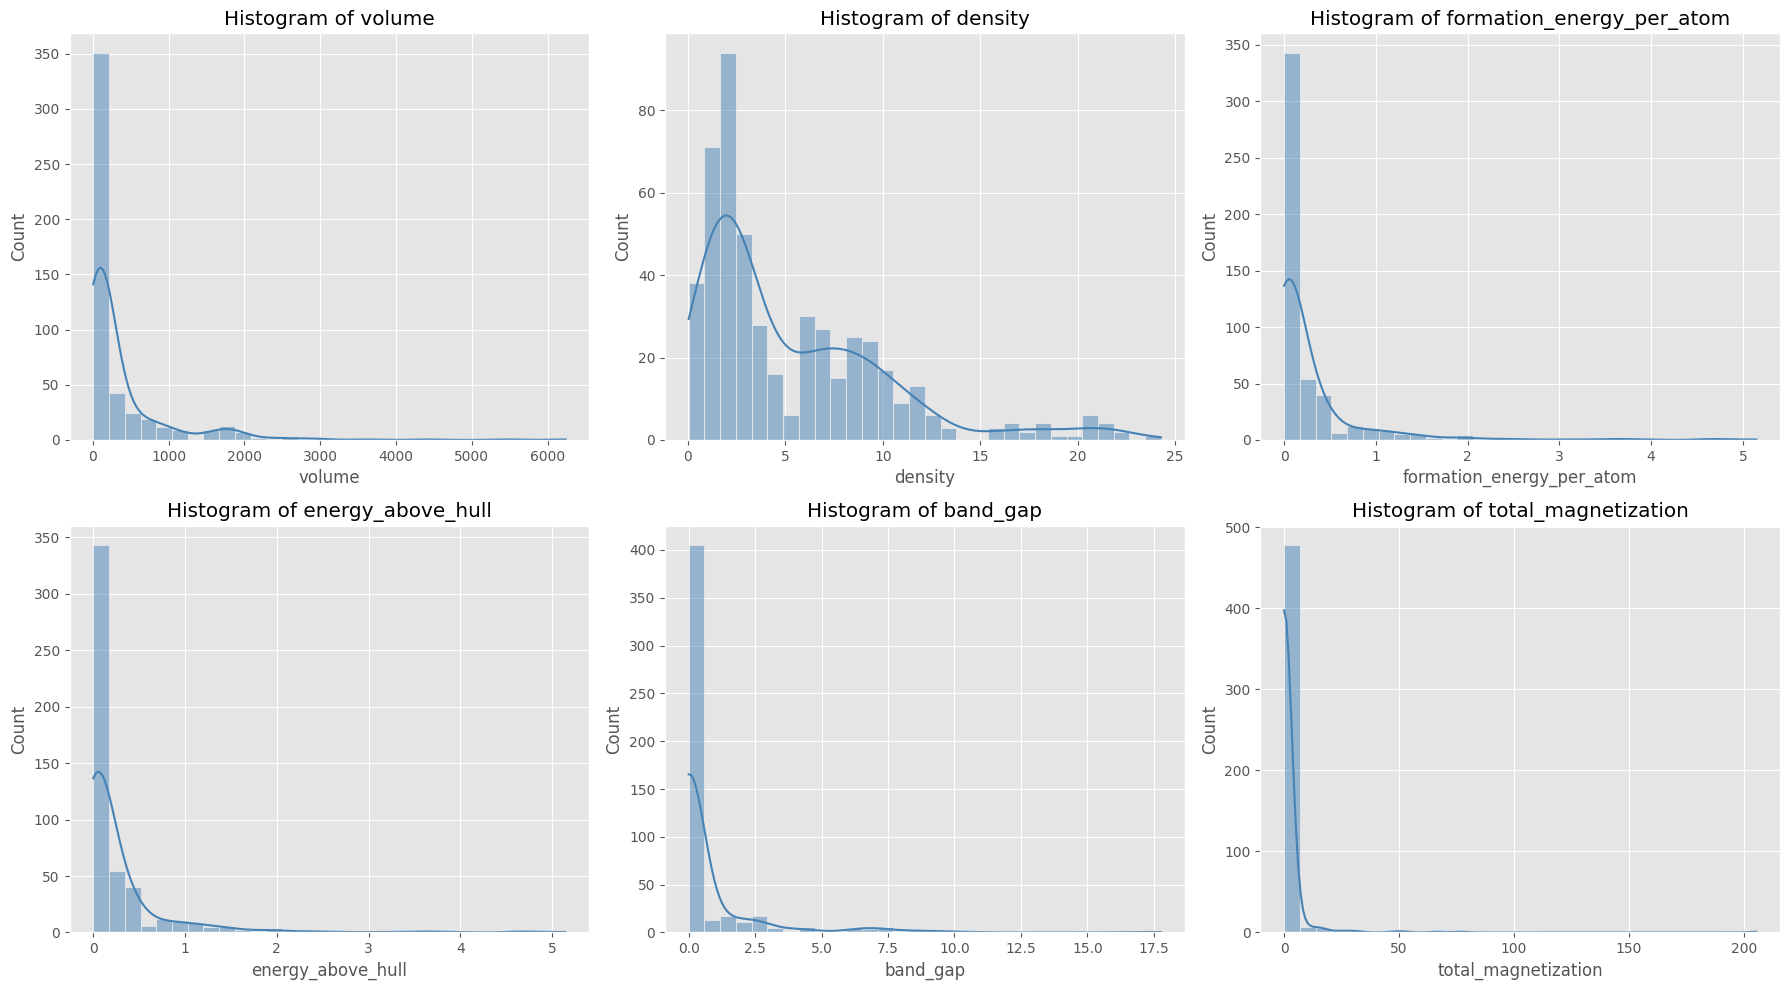

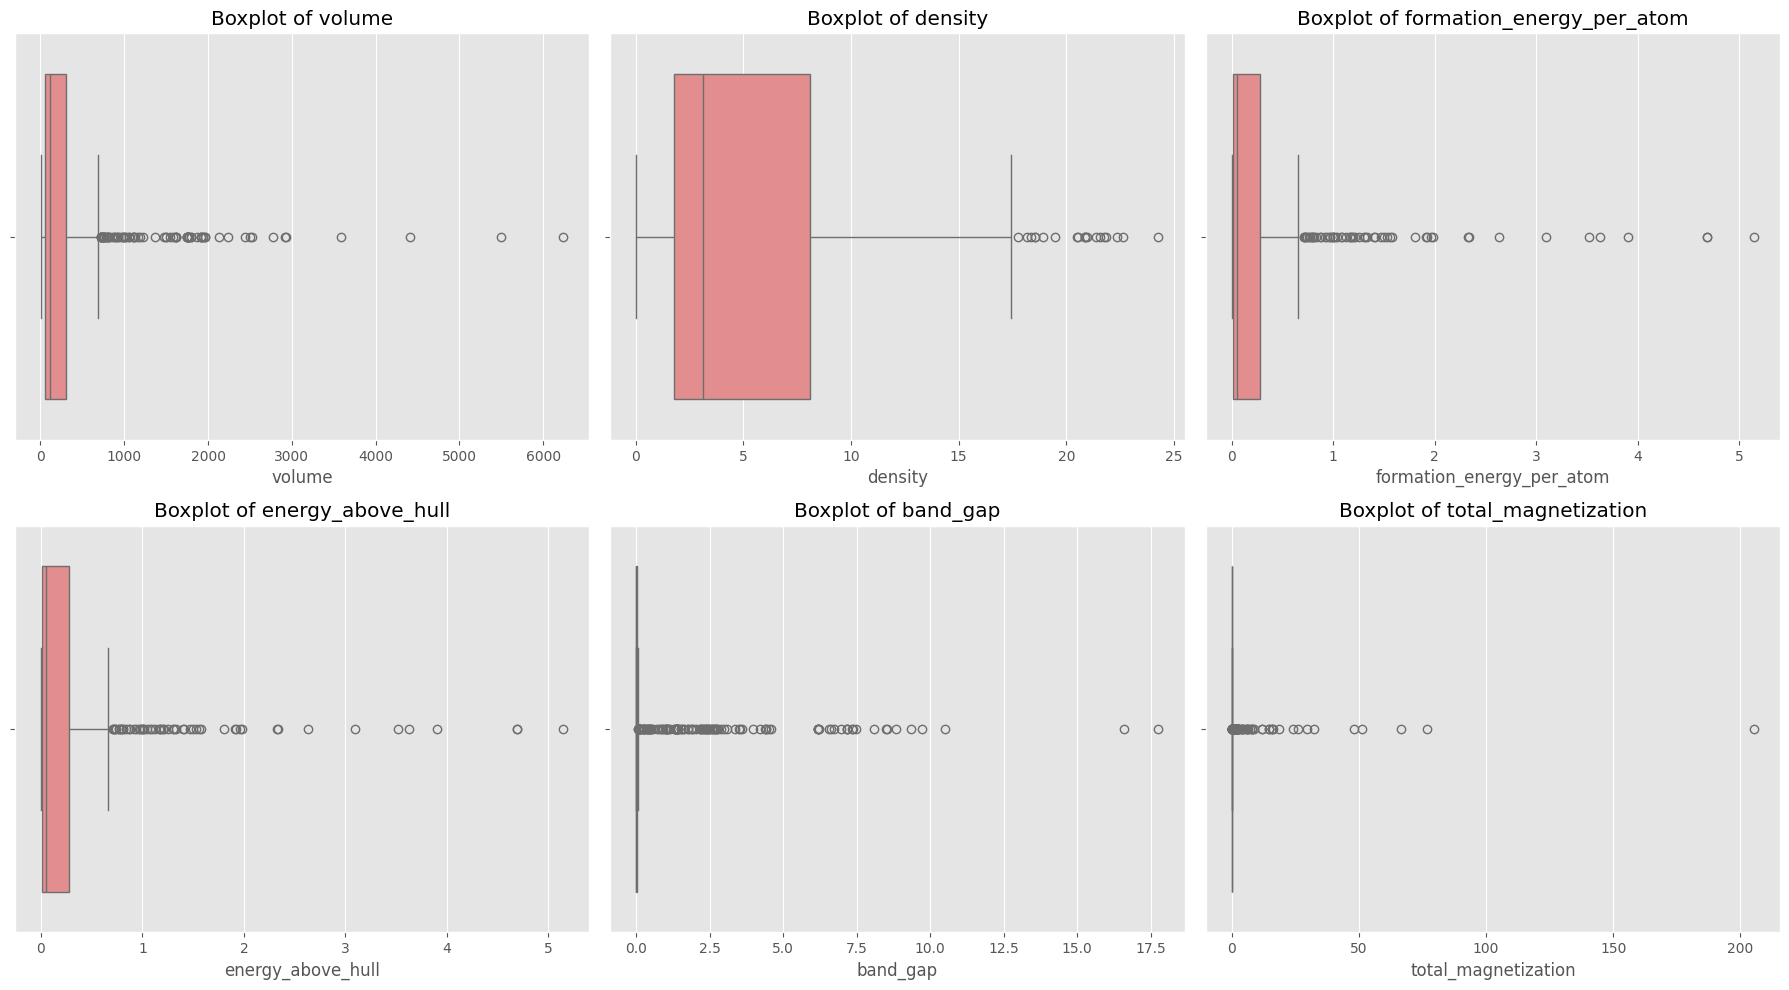

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up layout
features_to_plot = [
    "volume",
    "density",
    "formation_energy_per_atom",
    "energy_above_hull",
    "band_gap",
    "total_magnetization"
]

# Plot histograms
plt.figure(figsize=(18, 10))
for idx, feature in enumerate(features_to_plot):
    plt.subplot(2, 3, idx + 1)
    sns.histplot(df_subset[feature], kde=True, bins=30, color="steelblue")
    plt.title(f"Histogram of {feature}")
plt.tight_layout()
plt.show()

# Plot boxplots
plt.figure(figsize=(18, 10))
for idx, feature in enumerate(features_to_plot):
    plt.subplot(2, 3, idx + 1)
    sns.boxplot(x=df_subset[feature], color="lightcoral")
    plt.title(f"Boxplot of {feature}")
plt.tight_layout()
plt.show()


In [52]:
# Rebuild the subset with all required columns
df_subset = df[
    [
        "material_id", "formula_pretty", "volume", "density",
        "formation_energy_per_atom", "energy_above_hull",
        "band_gap", "total_magnetization", "nsites"
    ]
]

In [53]:
# Small constant to avoid division by zero
EPSILON = 1e-6

# Create new features
df_subset["magnetization_per_atom"] = df_subset["total_magnetization"] / df_subset["nsites"]
df_subset["volume_per_atom"] = df_subset["volume"] / df_subset["nsites"]
df_subset["stability_ratio"] = df_subset["formation_energy_per_atom"] / (df_subset["energy_above_hull"] + EPSILON)
df_subset["is_stable"] = (df_subset["energy_above_hull"] < 0.1).astype(int)

# View the new features
df_subset[["magnetization_per_atom", "volume_per_atom", "stability_ratio", "is_stable"]].head()

,magnetization_per_atom,volume_per_atom,stability_ratio,is_stable
0,3.999309e-01,15.926955,0.999997,0
1,2.000050e-02,11.903532,0.999999,0
2,3.869800e-05,17.443182,0.999993,0
3,1.000000e-09,17.937649,0.999997,0
4,9.983333e-06,18.903301,0.999995,0


In [54]:
import pandas as pd

# Load raw dataset
df_raw = pd.read_csv("materials_v2_raw.csv")

# Show all columns
print("📌 Columns in materials_v2_raw.csv:\n")
print(df_raw.columns.tolist())

# Preview the first few rows
df_raw.head()


📌 Columns in materials_v2_raw.csv:

['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'bulk_modulus', 'shear_modulus', 'universal_anisotropy', 'homogeneous_poisson', '

,builder_meta,nsites,elements,nelements,composition,composition_reduced,formula_pretty,formula_anonymous,chemsys,volume,...,weighted_surface_energy,weighted_work_function,surface_anisotropy,shape_factor,has_reconstructed,possible_species,has_props,theoretical,database_Ids,fields_not_requested
0,NaN,10,['O'],1,NaN,NaN,O2,NaN,NaN,159.269552,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['builder_meta', 'composition', 'composition_r..."
1,NaN,100,['C'],1,NaN,NaN,C,NaN,NaN,1190.353192,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['builder_meta', 'composition', 'composition_r..."
2,NaN,100,['Ti'],1,NaN,NaN,Ti,NaN,NaN,1744.318224,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['builder_meta', 'composition', 'composition_r..."
3,NaN,100,['Si'],1,NaN,NaN,Si,NaN,NaN,1793.764938,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['builder_meta', 'composition', 'composition_r..."
4,NaN,12,['Nb'],1,NaN,NaN,Nb,NaN,NaN,226.839615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['builder_meta', 'composition', 'composition_r..."


## Step 6: Cleaning and Preparing Raw Materials Dataset

In this section, I clean the raw materials dataset (`materials_v2_raw.csv`) obtained from the Materials Project API. This raw data contains a wide range of fields, many of which are either unnecessary for this project or contain missing values.

To ensure a smooth and consistent pipeline for machine learning modeling, I will:
1. Select only the relevant columns needed for feature engineering and prediction.
2. Drop any rows with missing values in those selected columns.
3. Create new engineered features such as:
   - `magnetization_per_atom`
   - `volume_per_atom`
   - `stability_ratio`
   - `is_stable` (binary indicator)
4. Save the clean processed dataset for future use as `clean_materials_dataset_v2.csv`.


In [55]:
import pandas as pd

# Load the raw dataset
df_raw = pd.read_csv("materials_v2_raw.csv")

# Define the columns we need
required_columns = [
    "nsites", "volume", "density", "formation_energy_per_atom", 
    "energy_above_hull", "band_gap", "total_magnetization"
]

# Check that all required columns exist
missing_cols = [col for col in required_columns if col not in df_raw.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")

# Drop rows with any missing values in the required columns
df = df_raw.dropna(subset=required_columns).copy()

# Recalculate engineered features
EPSILON = 1e-6
df["magnetization_per_atom"] = df["total_magnetization"] / df["nsites"]
df["volume_per_atom"] = df["volume"] / df["nsites"]
df["stability_ratio"] = df["formation_energy_per_atom"] / (df["energy_above_hull"] + EPSILON)
df["is_stable"] = (df["energy_above_hull"] < 0.1).astype(int)

# Save the cleaned dataset for later use
df.to_csv("clean_materials_dataset_v2.csv", index=False)
print("✅ Cleaned dataset saved as 'clean_materials_dataset_v2.csv'")

# Optional: preview first few rows
df.head()


✅ Cleaned dataset saved as 'clean_materials_dataset_v2.csv'


,builder_meta,nsites,elements,nelements,composition,composition_reduced,formula_pretty,formula_anonymous,chemsys,volume,...,shape_factor,has_reconstructed,possible_species,has_props,theoretical,database_Ids,fields_not_requested,magnetization_per_atom,volume_per_atom,stability_ratio
0,NaN,10,['O'],1,NaN,NaN,O2,NaN,NaN,159.269552,...,NaN,NaN,NaN,NaN,NaN,NaN,"['builder_meta', 'composition', 'composition_r...",3.999309e-01,15.926955,0.999997
1,NaN,100,['C'],1,NaN,NaN,C,NaN,NaN,1190.353192,...,NaN,NaN,NaN,NaN,NaN,NaN,"['builder_meta', 'composition', 'composition_r...",2.000050e-02,11.903532,0.999999
2,NaN,100,['Ti'],1,NaN,NaN,Ti,NaN,NaN,1744.318224,...,NaN,NaN,NaN,NaN,NaN,NaN,"['builder_meta', 'composition', 'composition_r...",3.869800e-05,17.443182,0.999993
3,NaN,100,['Si'],1,NaN,NaN,Si,NaN,NaN,1793.764938,...,NaN,NaN,NaN,NaN,NaN,NaN,"['builder_meta', 'composition', 'composition_r...",1.000000e-09,17.937649,0.999997
4,NaN,12,['Nb'],1,NaN,NaN,Nb,NaN,NaN,226.839615,...,NaN,NaN,NaN,NaN,NaN,NaN,"['builder_meta', 'composition', 'composition_r...",9.983333e-06,18.903301,0.999995


In [56]:
# Define the features and target for modeling
features = [
    "volume", "density", "formation_energy_per_atom", "energy_above_hull",
    "total_magnetization", "magnetization_per_atom", "volume_per_atom",
    "stability_ratio"
]
target = "band_gap"

# Split features and target
X = df[features]
y = df[target]

# Quick check
print("Features and target separated.")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


Features and target separated.
X shape: (500, 8)
y shape: (500,)


### Step 7: Exploratory Data Analysis – Correlation Heatmap

In this step, I will compute and visualize the correlation matrix between the selected features and the target variable (`band_gap`). This helps me understand which features have the strongest linear relationships with the band gap and with each other.

Highly correlated features may influence modeling decisions (e.g., regularization or feature selection), while uncorrelated ones might not contribute significantly to linear models.


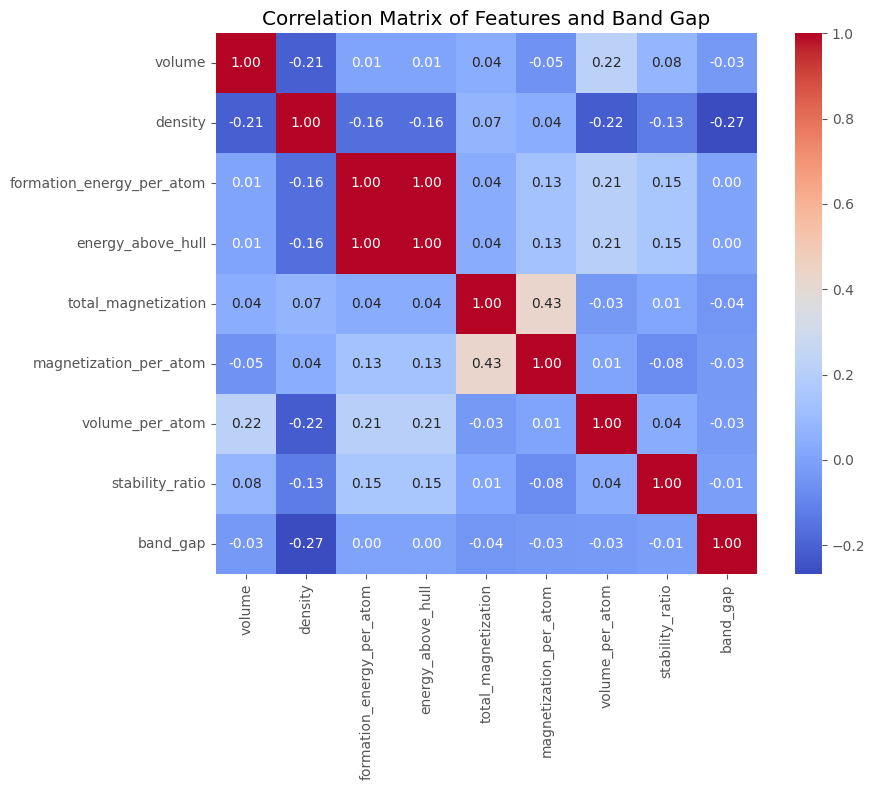

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

# Combine features and target for correlation matrix
df_corr = X.copy()
df_corr["band_gap"] = y

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)
plt.title("Correlation Matrix of Features and Band Gap")
plt.tight_layout()
plt.show()


### Step 8: Baseline Modeling – Linear Regression

#### What are we doing?

In this step, I am training a **Linear Regression** model to predict the `band_gap` of materials using the selected features from the cleaned and engineered dataset.

#### Why am I doing this?

- **Baseline Performance**: This model serves as a benchmark to measure how well more complex models (e.g., Random Forest, XGBoost) perform.
- **Interpretability**: Linear regression is easy to interpret, allowing me to understand the direction and relative weight of each feature's impact on `band_gap`.
- **Model Comparison**: It provides a reference point to evaluate the added value of more advanced modeling techniques.
- **Low Correlation Check**: The correlation matrix shows that the selected features are only weakly correlated with `band_gap`, so testing linear regression helps assess whether more expressive (non-linear) models are necessary.

This step will guide further modeling decisions and highlight whether linear assumptions are too simplistic for this problem.


In [58]:
# Step 8: Baseline Linear Regression Model

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Predict
y_pred = lin_reg.predict(X_test)

# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print("Linear Regression Performance on Test Set:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R²:   {r2:.4f}")


Linear Regression Performance on Test Set:
RMSE: 2.0261
MAE:  1.0589
R²:   0.0263


### Step 8.1: Linear Regression Results and Interpretation

#### Model Performance on Test Set:
- **Root Mean Squared Error (RMSE)**: 2.0261  
- **Mean Absolute Error (MAE)**: 1.0589  
- **R-squared (R²)**: 0.0263

#### What does this mean?

- The **low R² score (0.0263)** indicates that the linear regression model explains only about **2.6% of the variance** in the `band_gap`. This suggests that the relationship between the input features and the target is likely **non-linear** or more complex.
- An **RMSE of ~2.03** means that the model’s predictions deviate from the actual band gap by around 2 eV on average, which is relatively high depending on the physical application.
- The **MAE of ~1.06** further confirms a significant prediction error.

#### Implication:

This linear model serves as a **baseline**, but it is clear that more **expressive models (e.g., Random Forest, XGBoost)** will be necessary to capture complex, non-linear relationships in the material properties.



In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
rf_predictions = rf_model.predict(X_test)

# Evaluate
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_r2 = r2_score(y_test, rf_predictions)

print("Random Forest Performance on Test Set:")
print(f"RMSE: {rf_rmse:.4f}")
print(f"MAE:  {rf_mae:.4f}")
print(f"R²:   {rf_r2:.4f}")


Random Forest Performance on Test Set:
RMSE: 1.5182
MAE:  0.5737
R²:   0.4532


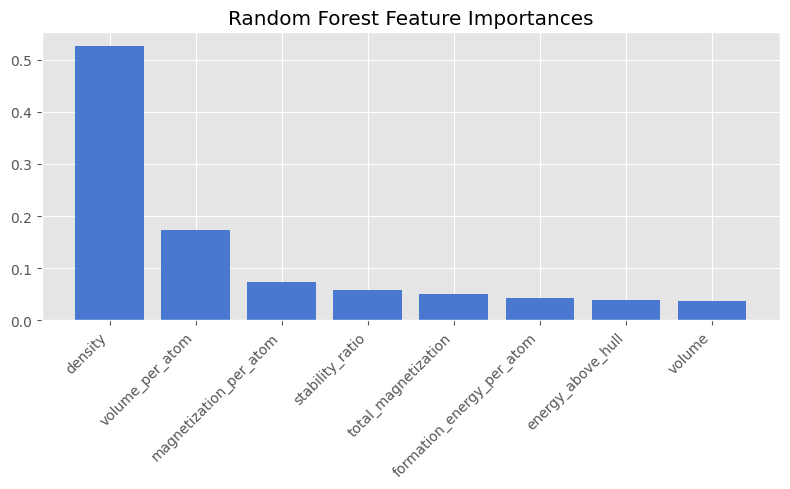

In [60]:
import matplotlib.pyplot as plt

# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = X.columns

# Sort features by importance
indices = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(8, 5))
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), feature_names[indices], rotation=45, ha='right')
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()


### Step 9.3 – Random Forest Feature Importance Analysis

To better understand which features most influenced the band gap predictions, I visualized the feature importances learned by the Random Forest model.

The plot shows that **density** was by far the most important feature, followed by **volume per atom**, **magnetization per atom**, and **stability ratio**. Interestingly, these top-ranked predictors include engineered features, reinforcing the value of careful feature design in materials informatics.

This insight can guide future feature selection, model design, and even scientific hypotheses around structure–property relationships in dual-functional materials.

Next, I will evaluate a more advanced model (e.g., XGBoost) and later introduce model interpretation using SHAP.


In [62]:
from xgboost import XGBRegressor

# Initialize and train the model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
rmse_xgb = mean_squared_error(y_test, y_pred_xgb) ** 0.5
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Performance on Test Set:")
print(f"RMSE: {rmse_xgb:.4f}")
print(f"MAE:  {mae_xgb:.4f}")
print(f"R²:   {r2_xgb:.4f}")


XGBoost Performance on Test Set:
RMSE: 1.2713
MAE:  0.5178
R²:   0.6167


In [65]:
pip install scikit-learn==1.6.1


  Using cached scikit_learn-1.6.1-cp313-cp313-win_amd64.whl.metadata (15 kB)
Using cached scikit_learn-1.6.1-cp313-cp313-win_amd64.whl (11.1 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.0
    Uninstalling scikit-learn-1.7.0:
      Successfully uninstalled scikit-learn-1.7.0
Note: you may need to restart the kernel to use updated packages.


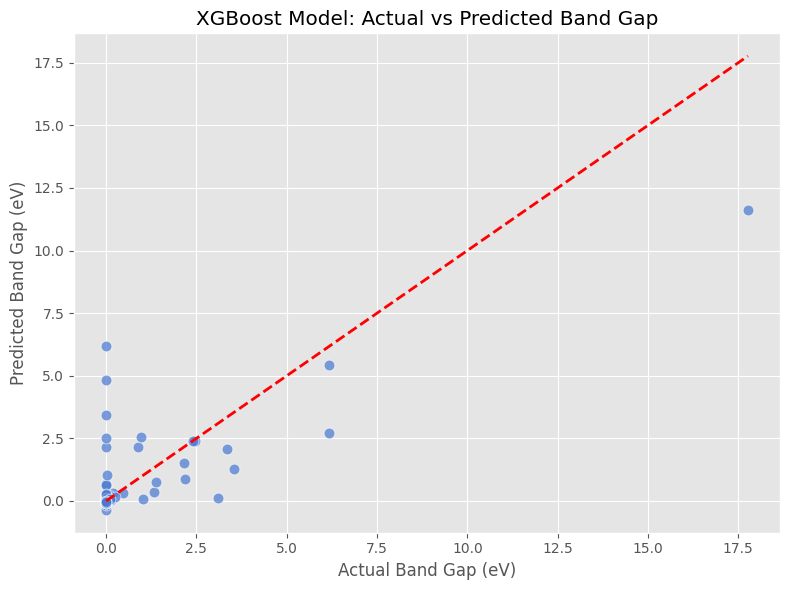

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.7, edgecolor="w", s=60)

# Reference line (perfect prediction)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# Labels and title
plt.xlabel("Actual Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("XGBoost Model: Actual vs Predicted Band Gap")
plt.grid(True)
plt.tight_layout()
plt.show()


### Step 7: Visualizing XGBoost Predictions

After training and evaluating the XGBoost model, I wanted to get a better visual sense of how well the predictions align with actual band gap values. This scatter plot compares the predicted values on the y-axis against the true values on the x-axis.

Each point represents a material in the test set. Ideally, the points should align along the red dashed line, which represents perfect prediction. The tighter the spread around this line, the better the model is performing.

This plot helps me visually validate the R² score and identify any systematic bias, underprediction, or overprediction patterns. The next step is to explore model interpretability using SHAP to understand what features are driving these predictions.


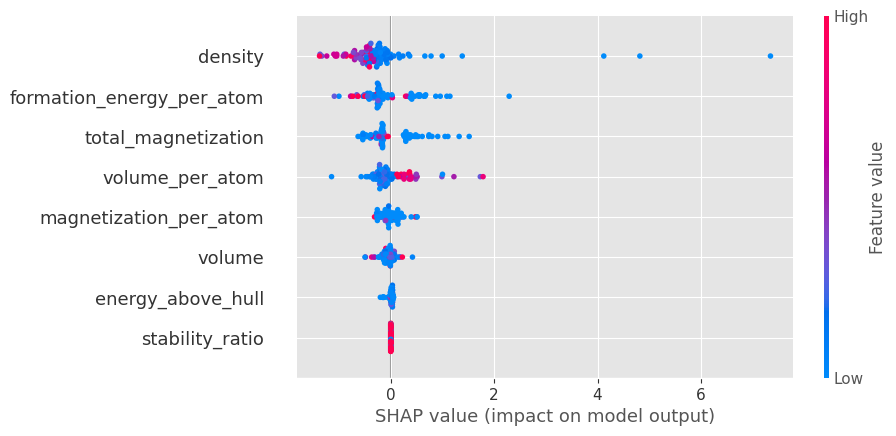

In [67]:
import shap

# Initialize the TreeExplainer for XGBoost
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)

# Summary plot (feature impact)
shap.plots.beeswarm(shap_values, max_display=10)


### Step 8: SHAP Interpretation of XGBoost Predictions

After evaluating my XGBoost model, I wanted to interpret *why* it made certain predictions. To do this, I used SHAP (SHapley Additive exPlanations), which is a game-theory-based approach to explaining individual predictions.

I applied SHAP’s TreeExplainer to the XGBoost model and generated a beeswarm plot to visualize feature importance and contribution direction.

From the plot, I can identify:

- Which features have the strongest influence on the model’s output.
- Whether they push the prediction higher or lower.
- How consistent their impact is across all samples.

This interpretability step is important not just for model trustworthiness, but also for scientific insight. For example, if features like `density` or `magnetization_per_atom` consistently push the band gap in one direction, that could inform how I reason about electronic properties in material design.

Next, I will export all outputs, ensure everything is reproducible, and then prepare this notebook for sharing and documentation.


In [72]:
# Step 9 – Save and Export Artifacts

# 1. Save the cleaned dataset (already saved earlier, but we confirm here)
df.to_csv("clean_materials_dataset_v2.csv", index=False)

# 2. Save the trained XGBoost model
import joblib
joblib.dump(xgb_model, "xgb_bandgap_model.joblib")

# 3. Save all plots (regenerate them in code before saving)
import matplotlib.pyplot as plt
import seaborn as sns

# 3a. Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Features and Band Gap")
plt.savefig("correlation_heatmap.png", dpi=300, bbox_inches='tight')
plt.close()

# 3b. Random Forest Feature Importances
plt.figure(figsize=(10, 6))
plt.bar(x=X.columns, height=rf_model.feature_importances_)
plt.xticks(rotation=45)
plt.title("Random Forest Feature Importances")
plt.savefig("rf_feature_importance.png", dpi=300, bbox_inches='tight')
plt.close()

# 3c. Actual vs Predicted (XGBoost)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Band Gap (eV)")
plt.ylabel("Predicted Band Gap (eV)")
plt.title("XGBoost Model: Actual vs Predicted Band Gap")
plt.savefig("xgb_actual_vs_predicted.png", dpi=300, bbox_inches='tight')
plt.close()

# 3d. SHAP Summary Plot
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')
plt.close()


## Step 9 – Save and Export Artifacts

In this step, I saved the key artifacts from this notebook to enable reproducibility, future reuse, and publication. These include:

- The cleaned dataset: `clean_materials_dataset_v2.csv`
- The trained XGBoost model: `xgb_bandgap_model.joblib`
- Visualizations:
  - Correlation heatmap
  - Random Forest feature importances
  - XGBoost actual vs predicted scatter plot
  - SHAP summary plot

Saving these artifacts allows me to reuse the trained model or pipeline for deployment or comparison, share results in a research notebook or GitHub repo, and ensure reproducibility of the study.


## Step 10.1 Discussion & Insights

This part of the analysis allowed me to explore how physical and engineered features of materials influence their band gap values. From the correlation matrix, I observed that no single feature had a very strong linear correlation with the band gap, suggesting that more complex models might be required to capture nonlinear relationships.

Linear Regression performed poorly with an R² of 0.03, indicating it was not well-suited for this task. On the other hand, the Random Forest and XGBoost models performed significantly better, with XGBoost achieving an R² of ~0.62. This confirms my earlier suspicion that the relationship between features and band gap is nonlinear.

Interestingly, the Random Forest model ranked **density** and **volume_per_atom** as the most important features, while SHAP analysis using XGBoost suggested **density** also had the strongest influence but also emphasized **formation_energy_per_atom** and **total_magnetization**. This difference highlights how model choice can influence interpretability and possibly lead to different scientific hypotheses.

I also noticed that some materials had outlier band gap values (~17 eV) that were hard to predict accurately. These could be true extremes or errors/artifacts worth investigating further.

Overall, these results align with known material science insights, for instance, structural compactness (density, volume) and formation energy do affect electronic properties like the band gap.


## Step 10.2 Conclusion

In this notebook, I set out to build a machine learning model that could predict the **band gap** of materials based on a combination of physical and engineered features. I started by cleaning a raw dataset containing structural and thermodynamic information about 500 materials, then engineered new features such as magnetization per atom and volume per atom.

After testing several models, I found that **XGBoost** performed the best with an R² of 0.62, indicating moderate predictive power. I also used feature importance and SHAP analysis to interpret the model, which provided insights into which material features had the greatest influence on band gap predictions.

This analysis forms a strong foundation for machine learning-based screening of sustainable materials, especially for energy and electronic applications where band gap is a key performance metric.


## Step 10.3 Next Steps

Moving forward, I plan to extend this workflow to other important target properties for sustainable electrochemical materials, including:

- `co2rr_overpotential`
- `specific_capacitance`
- `MCPI` (Material Cost Performance Index)

I will reuse the same base + engineered features and modeling pipeline, with possible modifications based on each property’s distribution and domain relevance.

I also intend to:
- Explore more advanced hyperparameter tuning (e.g., using `Optuna`)
- Implement experiment tracking with MLflow
- Scale up to larger datasets from Materials Project, NOMAD, or Open Catalyst Project (OCP)
- Package the pipeline into reusable scripts or modules
- Build a simple Streamlit app for material screening

These steps will push this project toward becoming a full-fledged, research-grade screening pipeline — a key asset for my PhD applications in ML for sustainable materials.


In [73]:
import joblib

# Save models
joblib.dump(lr_model, "linear_regression_model.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")
joblib.dump(xgb_model, "xgboost_model.pkl")

# Save SHAP values and explainer if needed
joblib.dump(shap_values, "shap_values_bandgap.pkl")
joblib.dump(explainer, "shap_explainer_bandgap.pkl")


['shap_explainer_bandgap.pkl']